In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import random
import os
import pickle
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from scipy.spatial.distance import pdist
from tqdm.auto import tqdm

path = Path(os.getcwd()).parent

In [2]:
def plot_auc_median(auc_score, std_aucs, drop, file_name, save=False, mrs_iteration=None):
    aucs_upper = np.minimum(auc_score + std_aucs, 1)
    aucs_younger = np.maximum(auc_score - std_aucs, 0)
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.fill_between(x_labels, aucs_younger, aucs_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score, color='blue', label='Median AUROC',  linestyle='-')
    plt.plot((len(x_labels)-1)*drop *[0.5], color='black', linestyle='--', label='Chance')
    if mrs_iteration is not None:
        minimum = min(0.5, np.min(aucs_younger))
        maximum = plt.gca().get_ylim()[1]
        plt.margins(0.05, 0)
        plt.vlines(mrs_iteration, minimum, maximum, colors='black', linestyles='solid')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

    
def plot_auc(auc_score, drop, file_name,  save=False, mrs_iteration=None):
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.plot(x_labels, auc_score, color='blue', linestyle='-', label='AUROC')
    plt.plot((len(x_labels)-1)*drop *[0.5], color='black', linestyle='--', label='Chance')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    if mrs_iteration is not None:
        minimum = min(0.5, np.min(auc_score - std_aucs))
        maximum = plt.gca().get_ylim()[1]
        plt.margins(0.05, 0)
        plt.vlines(mrs_iteration, minimum, maximum, colors='black', linestyles='solid')
        
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_rocs(rocs, file_name,  save=False):
    default_cycle = (cycler('linestyle',['-',':','-.', (0, (3, 5, 1, 5, 1, 5))]) +
                    cycler(color=['blue', 'orange', 'red', 'green']))
    plt.rc('')
    plt.rc('axes', prop_cycle=default_cycle)
    for fper, tper, std, deleted_elements in rocs:
        tpfrs_higher = np.minimum(tper + std, 1)
        tpfrs_lower = np.maximum(tper - std, 0)
        plt.plot(fper, tper, label=f'{int(deleted_elements[0])} samples removed')
        plt.fill_between(fper, tpfrs_lower, tpfrs_higher, alpha=0.2)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_mmds(mmds, drop, mmd_iteration, file_name, save=False):
    plt.plot([*range(0, len(mmds)* drop * mmd_iteration, drop * mmd_iteration)], mmds)
    plt.ylabel('Maximum Mean Discrepancy')
    plt.xlabel('Number of removed observations')
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_mmds_median(mmds, std, drop, mmd_iteration, file_name,  save=False):
    mmds_upper = np.minimum(mmds + std, 1)
    mmds_younger = np.maximum(mmds - std, 0)
    x_labels = [*range(0, len(mmds)* drop * mmd_iteration, drop * mmd_iteration)]
    plt.fill_between(x_labels, mmds_younger, mmds_upper, color='black', alpha=0.2)
    plt.plot(x_labels, mmds)
    plt.ylabel('Maximum Mean Discrepancy')
    plt.xlabel('Number of removed observations')
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_class_ratio(ratios, representative_ratio, file_name,  save=False):
    plt.xlabel('Removed Examples')
    plt.ylabel('Ratio Age')
    plt.plot(ratios, label='non-representative', linestyle='-', color='blue')
    plt.plot(len(ratios)*[representative_ratio], color='black', linestyle='--', label='representative')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
  
    
def plot_experiment_comparison_auc(auc_score_mrs, std_aucs_mrs, auc_score_experiment, std_aucs_experiment, 
                               experiment_label, drop, file_name,  save=False, first_label='MRS'):
    aucs_upper = np.minimum(auc_score_mrs + std_aucs_mrs, 1)
    aucs_lower = np.maximum(auc_score_mrs - std_aucs_mrs, 0)
    
    aucs_upper_experiment = np.minimum(auc_score_experiment + std_aucs_experiment, 1)
    aucs_lower_experiment = np.maximum(auc_score_experiment - std_aucs_experiment, 0)
    
    x_labels = range(0, (len(auc_score_mrs)*drop), drop)
    
    plt.fill_between(x_labels, aucs_lower, aucs_upper, color='orange', alpha=0.2)
    plt.plot(x_labels, auc_score_mrs, color='orange', linestyle='-', label=first_label)
    
    plt.fill_between(x_labels, aucs_lower_experiment, aucs_upper_experiment, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score_experiment, linestyle=':', color='blue', label=experiment_label)
    
    plt.plot(len(auc_score_mrs)*drop*[0.5], color='black', linestyle='--', label='Chance')
    
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_experiment_comparison_mmd(median_mmd, std_mmd,  median_mmd_experiment, std_mmd_experiment, 
                               experiment_label, drop, mmd_iteration, file_name,  save=False):
    mmd_upper = np.minimum(median_mmd + std_mmd, 1)
    mmd_lower = np.maximum(median_mmd - std_mmd, 0)
    
    mmd_upper_experiment = np.minimum(median_mmd_experiment + std_mmd_experiment, 1)
    mmd_lower_experiment = np.maximum(median_mmd_experiment - std_mmd_experiment, 0)
    
    x_labels = range(0, (len(median_mmd)*drop*mmd_iteration), mmd_iteration*drop)
    
    plt.fill_between(x_labels, mmd_lower, mmd_upper, color='orange', alpha=0.2)
    plt.plot(x_labels, median_mmd, color='orange', linestyle='-', label='MRS')
    
    plt.fill_between(x_labels, mmd_lower_experiment, mmd_upper_experiment, color='blue', alpha=0.2)
    plt.plot(x_labels, median_mmd_experiment, linestyle=':', color='blue', label=experiment_label)
    
    plt.ylabel('Maximum mean discrepancy')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

In [3]:
def stacked_histograms(representative_probabilities, nonrepresentative_propabilities, chosen_samples,
                       directory, iteration, save_figure=False, temperature=0):
    n_bins = 50
    labels = ['Representative', 'Nonrepresentative']
    vax = plt.axes()
    plt.xlabel('Probability of being non-representative')
    plt.ylabel('Number of elements')
    colors = ['blue', 'red']
    weights = ((np.ones(len(representative_probabilities)) / len(representative_probabilities)),
               (np.ones(len(nonrepresentative_propabilities)) / len(nonrepresentative_propabilities)))
    counts, bins, bars = plt.hist((representative_probabilities, nonrepresentative_propabilities), n_bins,
             histtype='bar', stacked=True, label=labels, color=colors, weights=weights)
    maximum = plt.gca().get_ylim()[1]
    plt.margins(0.05, 0)
    plt.vlines(chosen_samples, 0, maximum, colors='black', linestyles='dashed')
    plt.legend()
    if save_figure:
        os.makedirs(f'{directory}/histograms/', exist_ok=True)
        plt.savefig(f'{directory}/histograms/histogram_temperature_{temperature}_iteration_{iteration}.pdf')
    plt.show()

In [4]:
from sklearn.metrics.pairwise import rbf_kernel  

def calculate_rbf_gamma(aggregate_set):
    all_distances = pdist(aggregate_set.values, 'euclid')
    sigma = sum(all_distances)/len(all_distances)
    return 1 / (2 * (sigma ** 2))

def maximum_mean_discrepancy(x, y):
    gamma = calculate_rbf_gamma(pd.concat([x, y]))
    x_x_rbf_matrix = rbf_kernel(x, x, gamma)
    y_y_rbf_matrix = rbf_kernel(y, y, gamma)
    x_y_rbf_matrix = rbf_kernel(x, y, gamma)
    
    maximum_mean_discreprancy = x_x_rbf_matrix.mean() + y_y_rbf_matrix.mean() - 2 * x_y_rbf_matrix.mean()
    return maximum_mean_discreprancy

# MRS Algorithm

To alyoung statistical inference in social sciences, survey participants must be selected at random
from the target population. When samples are drawn from parts of the population that are
close to hand, subgroups might be over-represented. This leads to statistical analyses under
sampling bias, which in turn may produce similarly biased outcomes. This notebook uses machine learning to reduce this selection bias in a psychological survey (**GBS**) using auxiliary information (**GESIS**/**Allensbach**) from comparable studies that are known to be representative. The proposed algorithm is first tested on US national Census data.

In [5]:
def grid_search(X_train, y_train, cv=5):
    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    ccp_alphas[ccp_alphas < 0] = 0
    param_grid = {'ccp_alpha': ccp_alphas}
    grid = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

In [6]:
def temperature_sample(softmax: list,
                       temperature: float,
                       drop: int):
    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax)).astype('float64')
    softmax[softmax == 0] = EPSILON
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    count = 0
    while np.isnan(preds).any() and count < 100:
        preds = [0 if x != x else x for x in preds]
        preds = exp_preds / np.sum(exp_preds)
        count += 1
        
    if count == 100:
        return []
        
    if len(preds[preds != 0]) < drop:
        drop = len(preds[preds != 0]) 
    return np.random.choice(len(preds), drop, replace=False, p=preds)

In [7]:
def cv_bootstrap_prediction(N, R, number_of_splits, columns, cv):
    preds = np.zeros(len(N))
    preds_r = np.zeros(len(R))
    bootstrap_iterations = 10
    
    kf = KFold(n_splits=number_of_splits, shuffle=True)
    for split_n, split_r in zip(kf.split(N), kf.split(R)):
        train_index, test_index = split_n
        train_index_r, test_index_r  = split_r
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        R_train, R_test = R.iloc[train_index_r], R.iloc[test_index_r]
        n = min(len(R_train), len(N_train))
        r = n
        bootstrap_predictions = []
        bootstrap_predictions_r = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R_train.sample(n=r, replace=True)])
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
            bootstrap_predictions_r.append(clf.predict_proba(R_test[columns])[:,1])
        preds[test_index]  = np.mean(bootstrap_predictions, axis=0)
        preds_r[test_index_r] = np.mean(bootstrap_predictions_r, axis=0)
    return preds, preds_r

In [8]:
def auc_prediction(N, R, columns, test_size, drop, iteration, cv=5, calculate_roc=False):
    data = pd.concat([N, R])
    auroc_scores = []
    rocs = []
    median_roc = None
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for train, test in kf.split(data[columns], data['label']):
        train, test = data.iloc[train], data.iloc[test]
        y_train = train['label']
        clf = grid_search(train[columns], y_train, cv)
        y_predict = clf.predict_proba(test[columns])[:,1]
        y_test = test['label']
        auroc_scores.append(roc_auc_score(y_test, y_predict))
        if calculate_roc:
            rocs.append(interpolate_roc(y_test, y_predict, drop, iteration))
    if calculate_roc:
        median_roc = calculate_median_roc(rocs)
        
    return np.mean(auroc_scores), median_roc

In [9]:
def interpolate_roc(y_test, y_predict, drop, iteration):
    interpolation_points = 250
    median_fpr = np.linspace(0, 1, interpolation_points)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return (median_fpr, interp_tpr, [iteration * drop] * interpolation_points)

def calculate_median_roc(rocs):
    rocs = np.array(rocs)
    median_fpr = np.median(rocs[:, 0], axis = 0)
    median_tpr = np.median(rocs[:, 1], axis = 0)
    std_tpr = np.std(rocs[:, 1], axis = 0)
    removed_samples = rocs[0, 2]
    return (median_fpr, median_tpr, std_tpr, removed_samples)

def calculate_median_rocs(rocs):
    rocs = np.array(rocs)
    median_rocs = []
    for i in range(rocs.shape[1]):
        rocs_at_iteration = rocs[:, i]
        median_fpr = np.median(rocs_at_iteration[:, 0], axis = 0)
        median_tpr = np.median(rocs_at_iteration[:, 1], axis = 0)
        std_tpr = np.std(rocs_at_iteration[:, 1], axis = 0)
        removed_samples = rocs_at_iteration[0, 3]
        median_rocs.append((median_fpr, median_tpr, std_tpr, removed_samples))
    return median_rocs

In [10]:
def MRS_with_histogram(N, R, columns, number_of_splits = 5, temperature: float=0.5,
        n_drop: int=1, cv=5, directory='', iteration=0, temperature_sampling=True):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """ 
    
    preds, preds_r = cv_bootstrap_prediction(N, R, number_of_splits, columns, cv)
    all_preds = np.concatenate([preds, preds_r])
    all_true = np.concatenate([np.ones(len(preds)), np.zeros(len(preds_r))])
    auc = roc_auc_score(all_true, all_preds)
    
    if temperature_sampling:
        mapped_auc = abs(auc - 0.5)
        temperature = 0.35 * - np.log2(mapped_auc) - 0.35
        print("auc", auc)
    else:
        temperature = 1
    drop_ids = temperature_sample(preds, temperature, n_drop)
    
    if iteration % 5 == 0:
        stacked_histograms(preds_r, preds, np.array(preds)[drop_ids], directory, iteration, True, temperature)
    
    return N.drop(N.index[drop_ids])

In [11]:
def repeated_MRS(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, directory='', 
                 compas_bias='', temperature_sampling=True, number_of_iterations=None, mmd_iteration = 5):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    if number_of_iterations is None:
        number_of_iterations = int(len(N) / drop)
    aucs = []
    rocs = []
    ratio = []
    mmds = []
    kl_values = []
    
    
    auroc_iteration = int(int(len(N) / n_drop) / 4) + 1
    
    if us:
        representative_ratio = (len(R[R[compas_bias] == 1]) /
                                len(R[R[compas_bias] == 0]))
        ratio.extend([len(N[N[compas_bias] == 1]) / 
                         (len(N[N[compas_bias] == 0]))]*drop)
        
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    rocs.append(roc)
    plot_rocs(rocs, '', save=False)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    mrs = N
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS_with_histogram(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv, directory=directory, iteration=i,
                                temperature_sampling=temperature_sampling)
        
        
        
        if((i+1) % auroc_iteration == 0):
            auc, roc = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=True)
            aucs.append(auc)
            rocs.append(roc)
            plot_rocs(rocs, '', save=False)
        else:
            auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
            aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * n_drop
            mrs = N.copy(deep=True)
            
        print(f'graph auc: {auc}')
        
        # only for US Census experiment
        if us:
            ratio.extend([len(N[N[compas_bias] == 1]) / 
                         (len(N[N[compas_bias] == 0]))]*drop)
            if ((i+1) % 10 == 0):
                plot_class_ratio(ratio, representative_ratio, directory + '/tmp_ratio', save=False)
                 
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    
    if us:
        return ratio, aucs, rocs, mrs, mmds, mrs_iteration 
    else:
        return aucs, rocs, mrs, mmds, mrs_iteration 

## Experiment 1
### <font color='darkblue'>US National Census (Income)</font>  <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=27Y".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [67]:
columns = ['age', 'c_charge_degree', 'race', 'score_text', 'sex', 'priors_count', 
         'is_violent_recid', 'decile_score', 'is_recid']

df = pd.read_csv(os.path.join(path, 'data/compas/compas-scores.csv'))
df = df[columns]
df['sex'].replace('Male', 0, inplace=True)
df['sex'].replace('Female', 1, inplace=True)

df = df.replace('-1', np.NaN)
df = df.replace(-1, np.NaN)
df.dropna(inplace=True)

compas_bias = 'age'

ctg = [
    'score_text',
    'c_charge_degree',
    'race'
      ]

for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)
    
compas_columns = list(df.columns)
meta = ['label', 'index', compas_bias]
for m in meta:
    if m in compas_columns:
        compas_columns.remove(m)
        
        
compas_scaling_columns = [
    'priors_count',
    'decile_score'
]


scale = StandardScaler()
df[compas_scaling_columns] = scale.fit_transform(df[compas_scaling_columns])
df.reset_index(drop=True, inplace=True)

In [68]:
df = df.sample(frac=1)

age = 26
compas_bias = 'age'
df_copy = df.copy()
df_copy.loc[(df_copy.age <= age),'age'] = 1
df_copy.loc[(df_copy.age > age),'age'] = 0

df_old = df_copy[(df_copy[compas_bias] == 1)].copy()
df_young = df_copy[(df_copy[compas_bias] == 0)].copy()

rep_fraction = 0.2
bias_fraction = 0.3
young_normal = len(df_young)
old_normal = len(df_old)


#-----------------Simulate non-representative data---------------------#
rep = pd.concat([df_young.head(int(young_normal * 0.25)),
                df_old.head(int(old_normal * 0.25))],
                ignore_index=True) 

nonrep_more_young = pd.concat([df_young.tail(int(young_normal * (rep_fraction + bias_fraction))), 
                             df_old.tail(int(old_normal * (rep_fraction - 0.15)))],
                            ignore_index=True)

nonrep_more_old = pd.concat([df_young.tail(int(young_normal * (rep_fraction))),
                             df_old.tail(int(old_normal * (bias_fraction + rep_fraction)))], 
                             ignore_index=True)


#-----------------Simulate representative data---------------------#
rep2 = pd.concat([df_young.tail(int(young_normal * rep_fraction)),
                 df_old.tail(int(old_normal * rep_fraction))], 
                 ignore_index=True) 

rep['label'] = 0
nonrep_more_young['label'] = 1
nonrep_more_old['label'] = 1
rep2['label'] = 1

print("Current setting:")
print('Rep: \n', rep[compas_bias].value_counts())
print('Rep 2: \n', rep2[compas_bias].value_counts())
print('Nonrep_more_older: \n', nonrep_more_old[compas_bias].value_counts())
print('nonrep_more_younger: \n', nonrep_more_young[compas_bias].value_counts())

compas_nonrep_more_young = pd.concat([rep.copy(deep=True), nonrep_more_young.copy(deep=True)])
compas_nonrep_more_old = pd.concat([rep.copy(deep=True), nonrep_more_old.copy(deep=True)])
compas_rep = pd.concat([rep.copy(deep=True), rep2.copy(deep=True)])

Current setting:
Rep: 
 0    1934
1     822
Name: age, dtype: int64
Rep 2: 
 0    1547
1     657
Name: age, dtype: int64
Nonrep_more_older: 
 1    1644
0    1547
Name: age, dtype: int64
nonrep_more_younger: 
 0    3869
1     164
Name: age, dtype: int64


## Experiment 1 a)


### Simulate non-representative data. More younger than in R

| income      | Representative (R) | Non-Representative (N) |
|-------------|--------------------|------------------------|
| young (<=27Y) | 3715               | ????                   |
| old (>50K) | 1168               | ????                   |

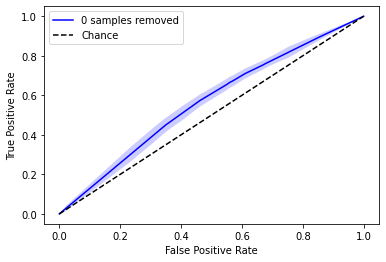

  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [69]:
drop = 50
number_of_splits = 3
test_size = 0.3
cv = 3
mmd_iteration = 5
number_of_iterations = int(len(compas_nonrep_more_young[compas_nonrep_more_young['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(compas_rep[compas_rep[compas_bias] == 1]) 
                        / len(compas_rep[compas_rep[compas_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_nonrep_more_young',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
save = True

ratio, auc_more_younger, roc, mrs, mmds, mrs_iteration = repeated_MRS(compas_nonrep_more_young, compas_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = cv, us = True, directory=result_dir, 
                                             compas_bias=compas_bias, 
                                             number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    
file_name = os.path.join(result_dir, 'ratio_more_young' + compas_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=save)   
plot_auc(auc_more_young, drop, f'{file_name}_auc', save=save, mrs_iteration=mrs_iteration, save=save)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

### Save results

In [70]:
pickle.dump(ratio, open("results/ratio_more_younger", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_more_younger", 'wb'))
pickle.dump(auc_more_younger, open("results/auc_more_younger", 'wb'))
pickle.dump(mmds, open("results/mmd_more_younger", 'wb'))

NameError: name 'ratio' is not defined

### Load results

In [ ]:
ratio = pickle.load(open("results/ratio_more_younger", 'rb'))
representative_ratio = pickle.load(open("results/representative_ratio_more_younger", 'rb'))
auc_more_younger = pickle.load(open("results/auc_more_younger", 'rb'))
mmds_younger = pickle.load(open("results/mmd_more_younger", 'rb'))

### Visualise results

In [ ]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/compas/more_younger/")
os.makedirs(file_directory, exist_ok=True)

plot_class_ratio(ratio, representative_ratio, file_directory+'ratio', save=save)
plot_auc(auc_more_younger, drop, file_directory+'auc', save=save)
plot_mmds(mmds_younger, drop, mmd_iteration, file_directory+'mmd', save)

## Experiment 1 b)


### Simulate non-representative data. More older than in R

| income      | Representative (R) | Representative (N)     |
|-------------|--------------------|------------------------|
| young (<=27Y) | 3715               | ????                   |
| old (>50K) | 1168               | ???                    |


In [ ]:
drop = 50
number_of_splits = 5
test_size = 0.3
mmd_iteration = 5
number_of_iterations = int(len(compas_nonrep_more_old[compas_nonrep_more_old['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(compas_rep[compas_rep[compas_bias] == 1])
                        / len(compas_rep[compas_rep[compas_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_nonrep_more_old',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
save = True
cv = 3

ratio, auc_more_old, roc, mrs, mmds, mrs_iteration = repeated_MRS(compas_nonrep_more_old, compas_columns,
                                                   number_of_splits = number_of_splits, n_drop = drop,
                                                   test_size = test_size, cv = cv, us = True, 
                                                   directory=result_dir, 
                                                   compas_bias=compas_bias, 
                                                   number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    

file_name = os.path.join(result_dir,  'ratio_more_old' + compas_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=save) 
plot_auc(auc_more_old, drop, file_name + '_auc', save=save, mrs_iteration=mrs_iteration)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

### Save results

In [ ]:
pickle.dump(ratio, open("results/ratio_more_older", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_more_older", 'wb'))
pickle.dump(auc_more_young, open("results/auc_more_older", 'wb'))
pickle.dump(mmds, open("results/mmd_more_older", 'wb'))

### Load results

In [ ]:
ratio = pickle.load(open("results/ratio_more_older", 'rb'))
representative_ratio = pickle.load(open("results/representative_ratio_more_older", 'rb'))
auc_more_older = pickle.load(open("results/auc_more_older", 'rb'))
mmd_more_older = pickle.load(open("results/mmd_more_older", 'rb'))

### Visualise results

In [ ]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/compas/more_older/")
os.makedirs(file_directory, exist_ok=True)


plot_class_ratio(ratio, representative_ratio, file_directory+'ratio', save=save)
plot_auc(auc_more_older, drop, file_directory+'auc', save=save)
plot_mmds(mmd_more_older, drop, mmd_iteration, file_directory+'mmd', save)

## Experiment 1 c)


### Simulate already representative data

| income      | Representative (R) | Second Representative (N)     |
|-------------|--------------------|------------------------|
| young (<=27Y) | 3715               | 3715                   |
| old (>27Y) | 1168               | 1168                   |

*Here we run the MRS algorithm to test whether the ratio young-old is still maintained.*

In [ ]:
drop = 50
number_of_splits = 5
test_size = 0.3
number_of_iterations = int(len(compas_rep[compas_rep['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(compas_rep[compas_rep[compas_bias] == 1]) / len(compas_rep[compas_rep[compas_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_rep',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
cv = 3
mmd_iteration = 5
save = True

ratio, auc_same, roc, new_same, mmds, mrs_iteration = repeated_MRS(compas_rep, compas_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = cv, us = True, directory=result_dir, 
                                            compas_bias=compas_bias, 
                                            number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    
file_name = os.path.join(result_dir, 'ratio_rep'  + compas_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=True) 
plot_auc(auc_rep, drop, file_name + '_auc', save=True, mrs_iteration=mrs_iteration)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

### Save results

In [ ]:
pickle.dump(ratio, open("results/ratio_same", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_same", 'wb'))
pickle.dump(auc_same, open("results/auc_same", 'wb'))
pickle.dump(mmds, open("results/mmd_same", 'wb'))

### Load results

In [ ]:
ratio = pickle.load(open("results/ratio_same", 'rb'))
representative_ratio = pickle.load(open("results/representative_ratio_same", 'rb'))
auc_same = pickle.load(open("results/auc_same", 'rb'))
mmd_same = pickle.load(open("results/mmd_same", 'rb'))

### Visualise results

In [ ]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/compas/more_older/")
os.makedirs(file_directory, exist_ok=True)


plot_class_ratio(ratio, representative_ratio, file_directory+'ratio', save=save)
plot_auc(auc_same, drop, file_directory+'auc', save=save)
plot_mmds(mmd_same, drop, mmd_iteration, file_directory+'mmd', save)

## Experiment 2
### <font color='darkgreen'>Allensbach</font>   <---MRS---> <font color='darkred'>GBS</font> <---MRS---> <font color='darkgreen'>GESIS</font> 

*Figure shows MRS concept on GBS and GESIS for experiment 2 a). Replace Allensbach with GESIS for experiment 2 b)*

<img src="overview.PNG" width="450" height="450"/>


**Multivariate auxiliary information GESIS linked to GBS so that expected selection bias can be detected and corrected for. In addition, GBS contains an attribute for positive and negative treatment of survey participents for further analysis (Experiment 4).**


## Experiment 2 a)
### <font color='darkgreen'>Allensbach Studie - Institut für Demoskopie(IfD)</font>  <a name="us"></a>

### <font color='darkred'>Important note:</font>  <a name="allensbach"></a> Allensbach is already merged with GBS in this data set


In [14]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_columns = ['Alter', 'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Berufsgruppe', 'Erwerbstaetigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']

scaler = StandardScaler()
scaled_allensbach = allensbach.copy(deep=True)
scaled_allensbach[allensbach_columns] = scaler.fit_transform(scaled_allensbach[allensbach_columns])

  0%|          | 0/3 [00:00<?, ?it/s]

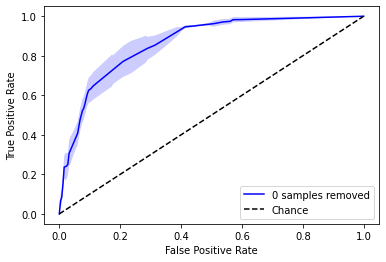

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.8934394100858657


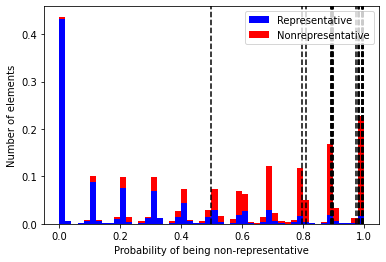

graph auc: 0.8632280588110234
auc 0.8878086184803157
graph auc: 0.8592522683776969
auc 0.8863430768825905
graph auc: 0.8459363483219914
auc 0.8744730387132921
graph auc: 0.8243579637078753
auc 0.8775130047328699
graph auc: 0.8341859086322


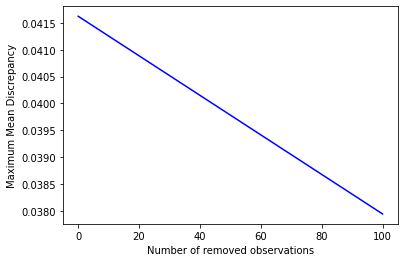

auc 0.862966212114482


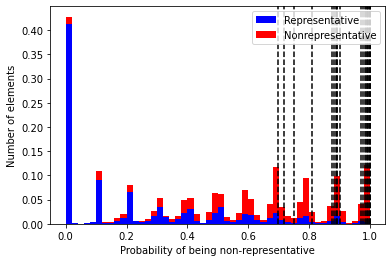

graph auc: 0.8286968177391417
auc 0.8693573371034782
graph auc: 0.8327282097755091
auc 0.8702998029047319


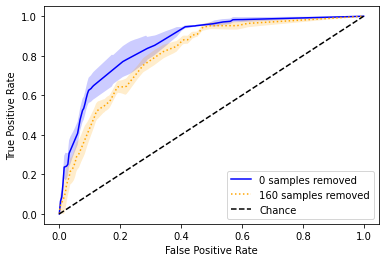

graph auc: 0.815258865494285
auc 0.8598486771949424
graph auc: 0.8087122431325691
auc 0.8460413000586572
graph auc: 0.8181202453035243


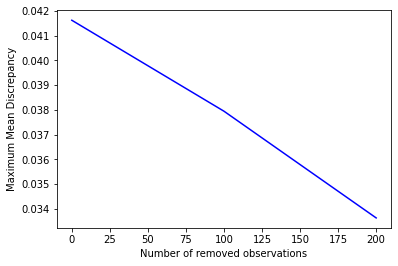

auc 0.8576542880667677


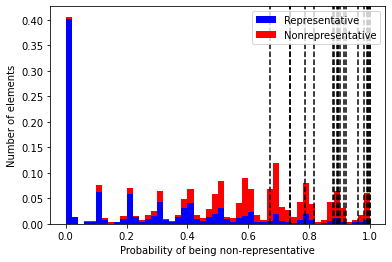

graph auc: 0.7960282805760599
auc 0.847760969201288
graph auc: 0.7692924601355533
auc 0.8495235255967698
graph auc: 0.7840475927096502
auc 0.8200271237688699
graph auc: 0.7767028170813681
auc 0.8198175359946867
graph auc: 0.7380012322976924


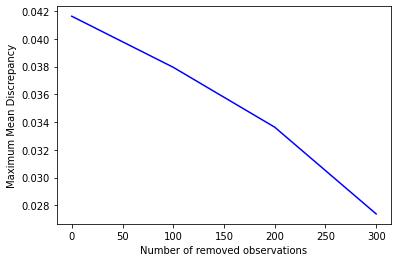

auc 0.817638030961641


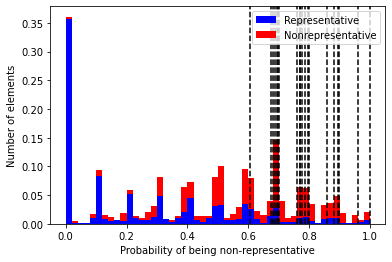

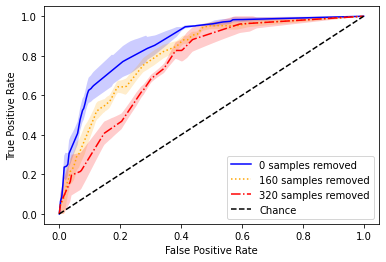

graph auc: 0.7644686394639544
auc 0.7955618992853035
graph auc: 0.7608940188776613
auc 0.7967873675776729
graph auc: 0.6445273292713095
auc 0.7899138573140322
graph auc: 0.6810414303002799
auc 0.7764754624184754
graph auc: 0.647196656833825


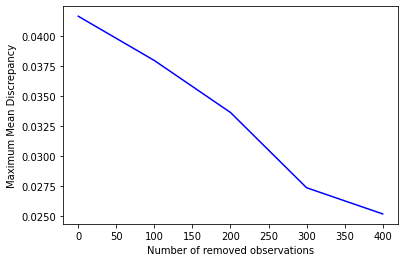

auc 0.7545712983874163


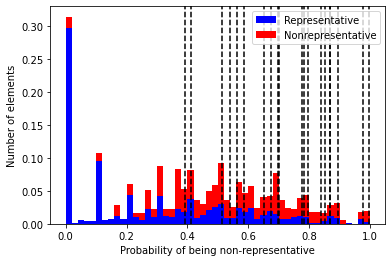

graph auc: 0.632655604719764
auc 0.738360876934743
graph auc: 0.6083470056655897
auc 0.7218193530282158
graph auc: 0.5972000983284169
auc 0.7477948626259014


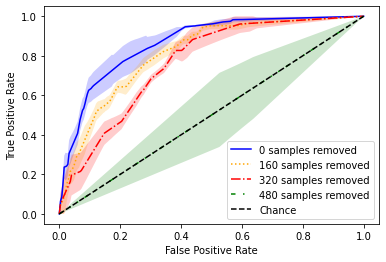

graph auc: 0.5736283185840708
auc 0.7155508990615375
graph auc: 0.5389380530973451


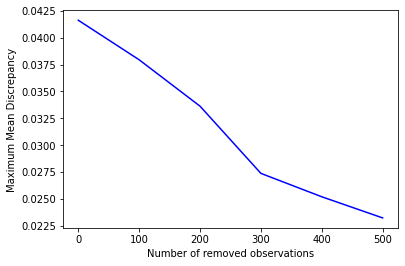

auc 0.7004219409282699


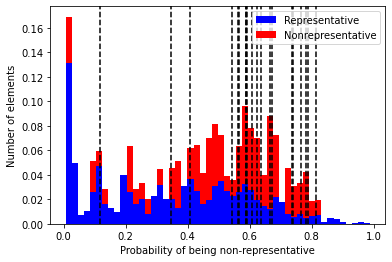

graph auc: 0.5037811745776348
auc 0.6976800096165404
graph auc: 0.5513483284169125
auc 0.6749181669394435
graph auc: 0.49734513274336284


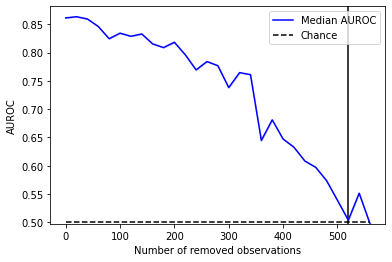

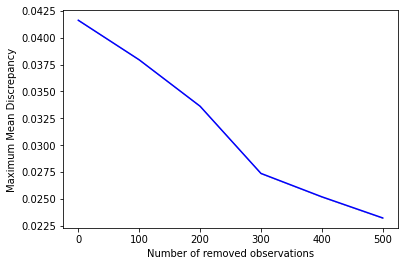

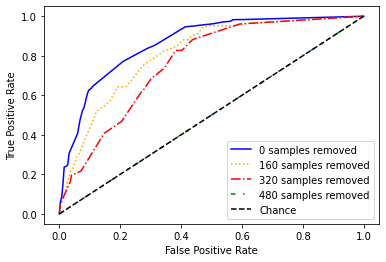

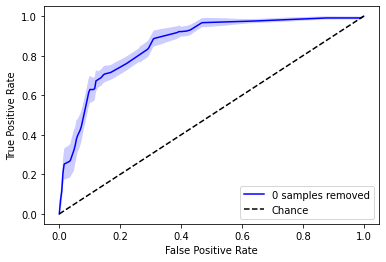

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.8886806550790675


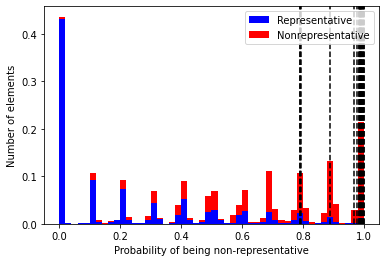

graph auc: 0.8588442410488872
auc 0.8816505220822392
graph auc: 0.8376001743295781
auc 0.8821300280266845
graph auc: 0.8357320989408583
auc 0.8863420516814933
graph auc: 0.8441979815857691
auc 0.8736977501101493
graph auc: 0.8196735173109765


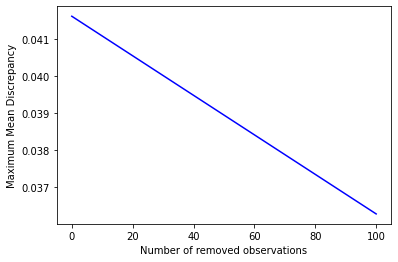

auc 0.8772533277069545


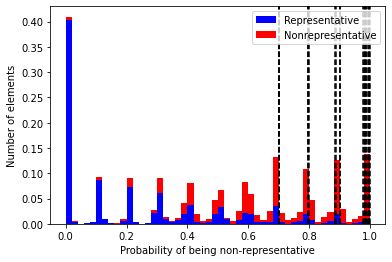

graph auc: 0.8259032956697443
auc 0.8752771597212565
graph auc: 0.8135287209908053
auc 0.8594777379279148


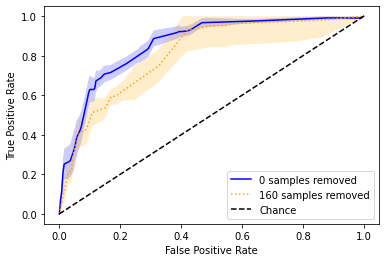

graph auc: 0.7882572430471994
auc 0.8528940063305065
graph auc: 0.8068817510548524
auc 0.8534456709148758
graph auc: 0.8098120633442012


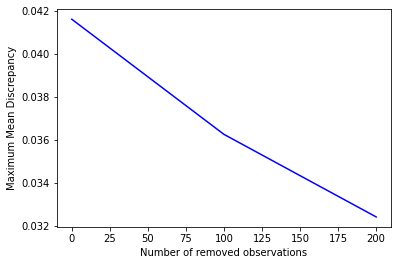

auc 0.8443505679372743


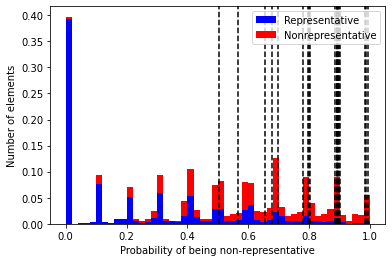

graph auc: 0.8005376075418973
auc 0.8451137418755802
graph auc: 0.7747465418871287
auc 0.8396632251720748
graph auc: 0.7590392786908274
auc 0.8247362658129348
graph auc: 0.7472890272153059
auc 0.8145339666500628
graph auc: 0.7027924887305417


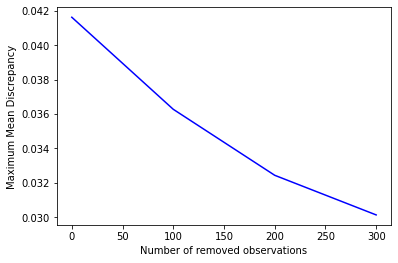

auc 0.7804246422125627


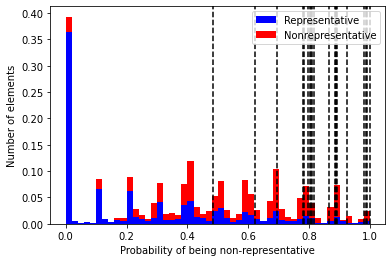

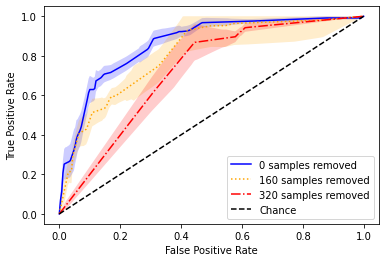

graph auc: 0.7075121509007506
auc 0.7986544675374463
graph auc: 0.6241994497792841
auc 0.7867203032730942
graph auc: 0.6361599073675632
auc 0.7854407526150458
graph auc: 0.6612790787383707
auc 0.751764139848177
graph auc: 0.669024223127468


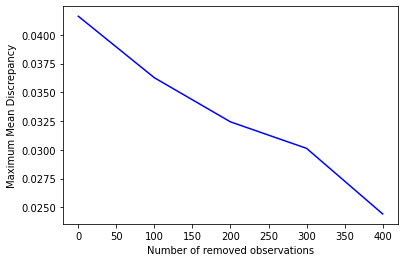

auc 0.7727995364317127


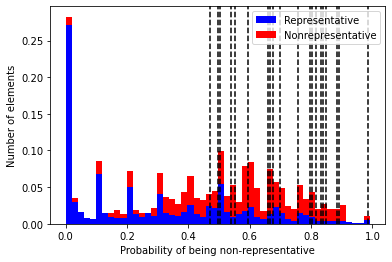

graph auc: 0.6267316248770894
auc 0.7579619965208082
graph auc: 0.5
auc 0.7535365324761468
graph auc: 0.5329277286135693
auc 0.7280529232969783


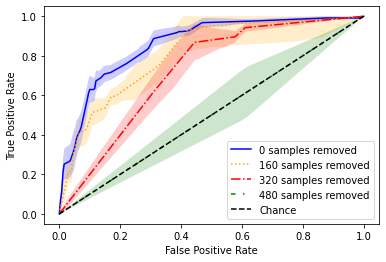

graph auc: 0.5525291103865859
auc 0.7153628483415717
graph auc: 0.5470390855457227


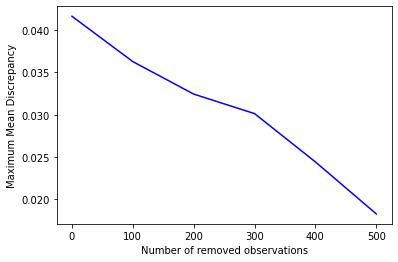

auc 0.6763062213843253


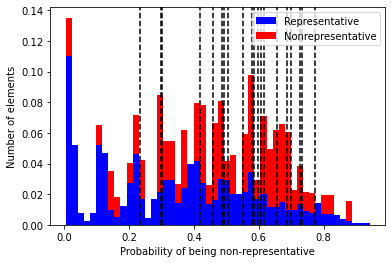

graph auc: 0.5013274336283186
auc 0.6249849741555475
graph auc: 0.5
auc 0.6288416075650117
graph auc: 0.5273529990167158


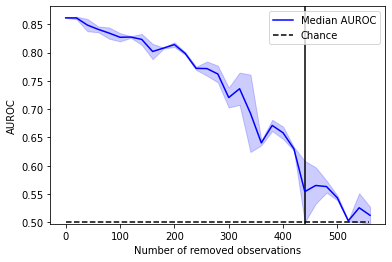

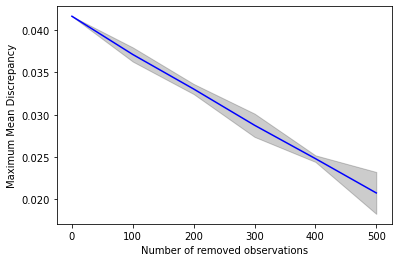

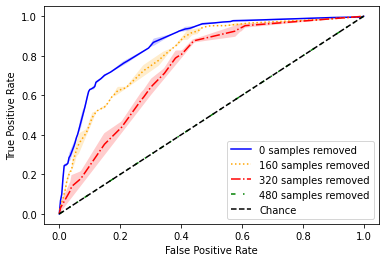

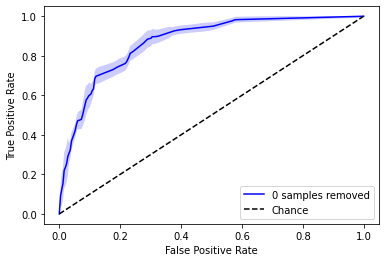

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.8868915285586545


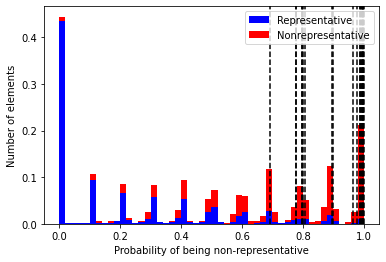

graph auc: 0.8738979510483935
auc 0.8824886765881323
graph auc: 0.8646831565021496
auc 0.8830445137436018
graph auc: 0.8506246802857766
auc 0.8858740212356003
graph auc: 0.8344657334406007
auc 0.8717150613283304
graph auc: 0.8417311375476547


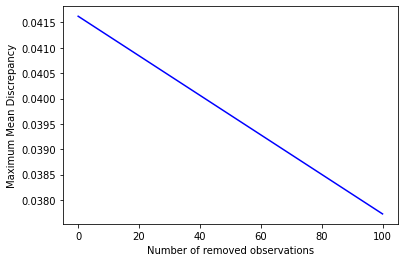

auc 0.8742735678644931


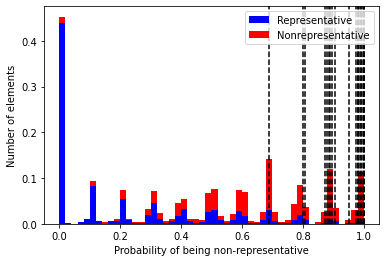

graph auc: 0.8497688669118066
auc 0.8576480631653763
graph auc: 0.7871698916229737
auc 0.8568413867752307


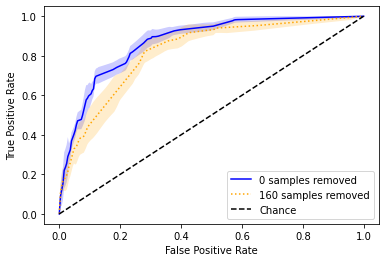

graph auc: 0.830117895941118
auc 0.854414216557491
graph auc: 0.8156015054205096
auc 0.8464012424678717
graph auc: 0.8151930859597372


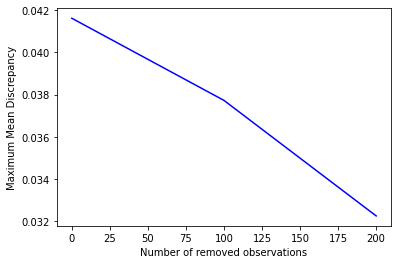

auc 0.840693360654204


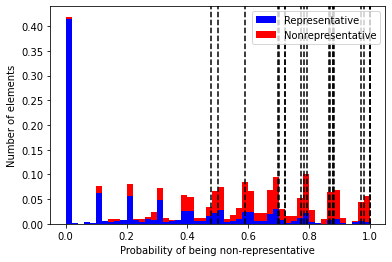

graph auc: 0.7801378663656802
auc 0.8181599300657856
graph auc: 0.7795777351313882
auc 0.8192090838720474
graph auc: 0.721554633726647
auc 0.8407131661442007
graph auc: 0.7575900727185864
auc 0.8229826371593254
graph auc: 0.7456769783805182


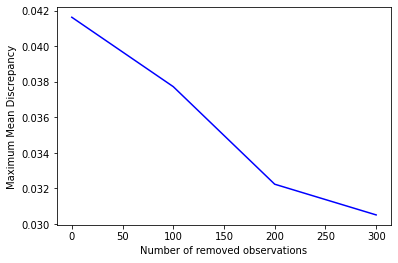

auc 0.8101248125270089


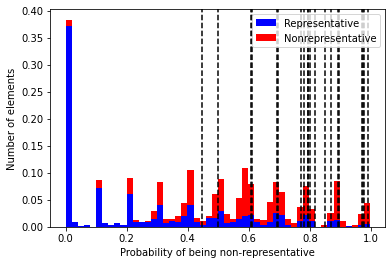

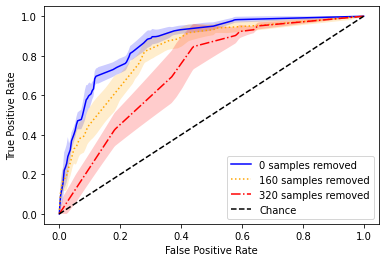

graph auc: 0.7187222288960966
auc 0.8051990059968783
graph auc: 0.7357231497172186
auc 0.7988089409181282
graph auc: 0.6929880259686805
auc 0.789377489556009
graph auc: 0.7063535549504575
auc 0.7618366655974911
graph auc: 0.6951157075744098


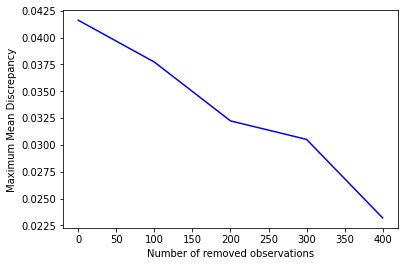

auc 0.7532885613534609


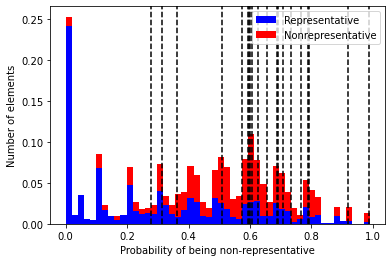

graph auc: 0.6070253215497827
auc 0.7420073375262055
graph auc: 0.5881047899985953
auc 0.7279963263431808
graph auc: 0.5365828096276346
auc 0.7002428631026879


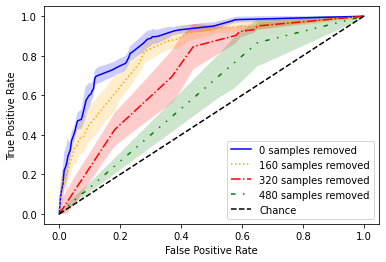

graph auc: 0.5782734875536925
auc 0.6469347732645605
graph auc: 0.5576553588987218


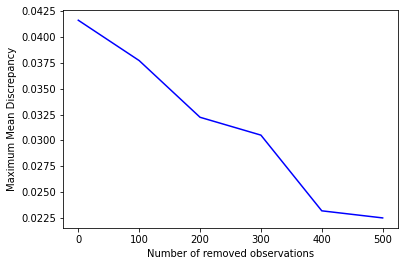

auc 0.6875224436663974


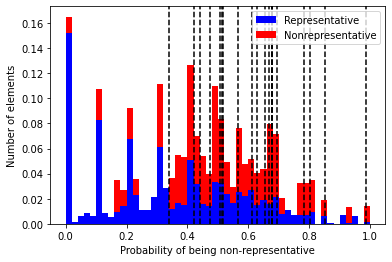

graph auc: 0.5047566371681416
auc 0.6387561605962255
graph auc: 0.49512487708947883
auc 0.6065648299690853
graph auc: 0.5619547689282203


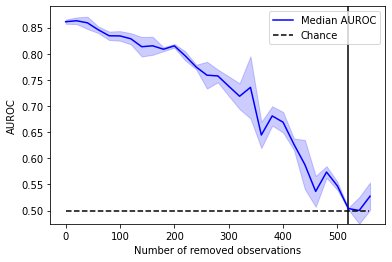

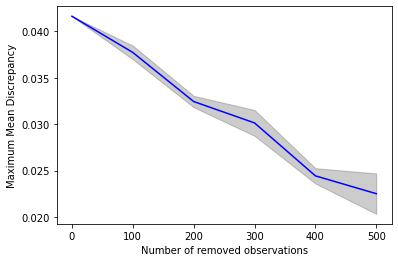

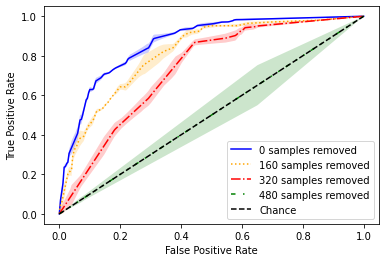

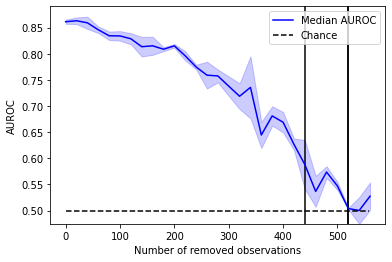

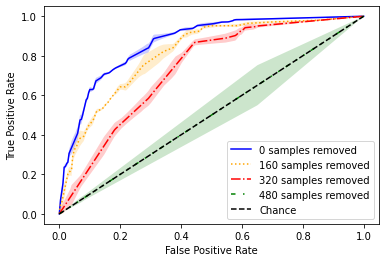

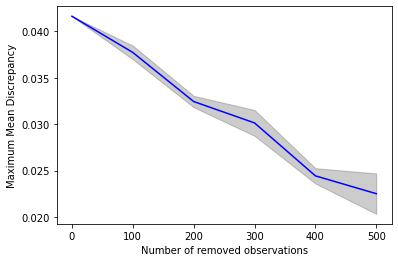

In [15]:
drop = 20
number_of_splits = 5
cv = 5
result_dir_allensbach = os.path.join(os.getcwd(), 'results/gbs_allensbach', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_allensbach, exist_ok=True)

test_size = 0.3
number_of_iterations = int(len(scaled_allensbach[scaled_allensbach['label']  == 1]) / drop)

aucs = []
rocs = []
mmds = []
mmd_iteration = 5
mrs_iterations = []

for _ in tqdm(range(3)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_allensbach, allensbach_columns,
                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=cv, directory=result_dir_allensbach)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iteration)
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_rocs(median_rocs, '', save=False)
     
plot_auc_median(median_aucs, std_aucs, drop, result_dir_allensbach + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_allensbach + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_allensbach + "/median_mmds", save=True)

    
pickle.dump(median_aucs, open(result_dir_allensbach + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_allensbach + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_allensbach + "/median_roc", 'wb'))
pickle.dump(median_mmds, open(result_dir_allensbach + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_allensbach + "/std_mmds", 'wb'))

### Save results

In [16]:
pickle.dump(median_aucs, open("results/allensbach_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/allensbach_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/allensbach_median_rocs", 'wb'))

pickle.dump(median_mmds, open("results/allensbach_median_mmds", 'wb'))
pickle.dump(std_mmds, open("results/allensbach_std_mmds", 'wb'))
pickle.dump(mrs_iterations, open("results/allensbach_mrs_iterations", 'wb'))

### Load  results

In [17]:
allensbach_median_aucs = pickle.load(open("results/allensbach_median_aucs", "rb"))
allensbach_std_aucs = pickle.load(open("results/allensbach_std_aucs", "rb"))
allensbach_rocs = pickle.load(open("results/allensbach_median_rocs", "rb"))
allensbach_mrs_iterations =  pickle.load(open("results/allensbach_mrs_iterations", 'rb'))
allensbach_median_mmds =  pickle.load(open("results/allensbach_median_mmds", 'rb'))
allensbach_std_mmds =  pickle.load(open("results/allensbach_std_mmds", 'rb'))

### Visualise results

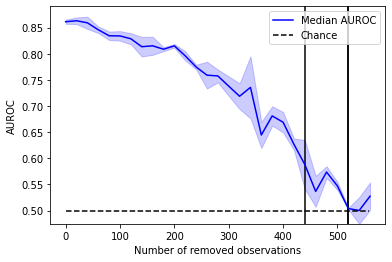

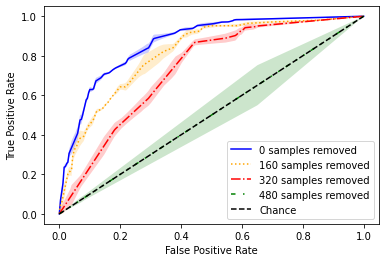

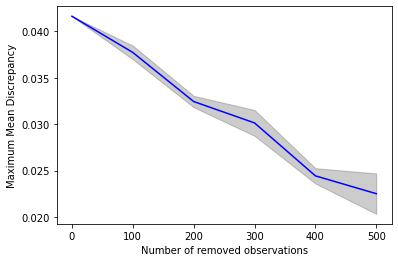

In [18]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/allensbach/")
os.makedirs(file_directory, exist_ok=True)

plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, drop, file_directory+"allensbach_auc", save=save, 
                mrs_iteration=allensbach_mrs_iterations)
plot_rocs(allensbach_rocs, file_directory+"allensbach_rocs", save=save)
plot_mmds_median(allensbach_median_mmds, allensbach_std_mmds, drop, mmd_iteration, 
                 file_directory + "median_mmds", save=save)

### Experiment 2 b)


### <font color='darkgreen'>Load Gesis</font>  <a name="us"></a>

In [22]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gesis_columns = ['Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

N = gbs.copy()
R = gesis.copy()

N['label'] = 1
R['label'] = 0

gesis_gbs = pd.concat([N, R], ignore_index=True)

In [23]:
scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_columns] = scaler.fit_transform(scaled_gesis_gbs[gesis_columns])

  0%|          | 0/3 [00:00<?, ?it/s]

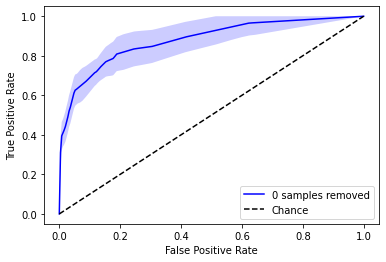

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.9115797235232834


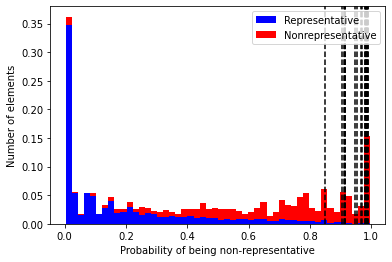

graph auc: 0.8529616871674655
auc 0.9097758874970476
graph auc: 0.814923446763008
auc 0.9058366237870659
graph auc: 0.8554662651125152
auc 0.9067487714438986
graph auc: 0.8435989041527308
auc 0.9045141353547292
graph auc: 0.8351633188623536


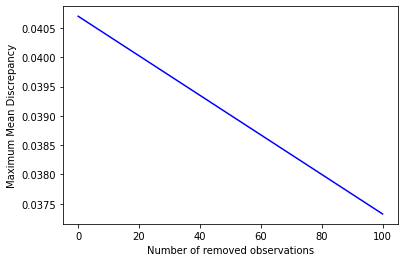

auc 0.893233137012221


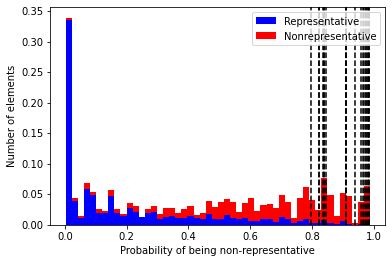

graph auc: 0.8439196656716742
auc 0.8892895983214812
graph auc: 0.8393426118024113
auc 0.8915207705310267


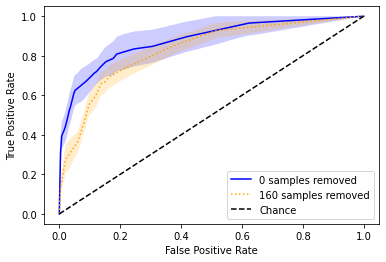

graph auc: 0.8263922520261883
auc 0.8845518052541914
graph auc: 0.7812612728434398
auc 0.8694895629282667
graph auc: 0.7758000790585903


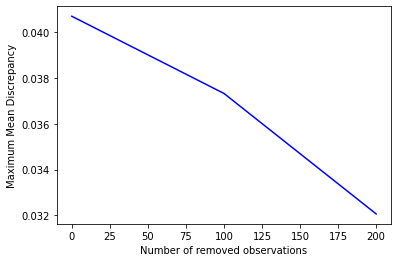

auc 0.8719965771862509


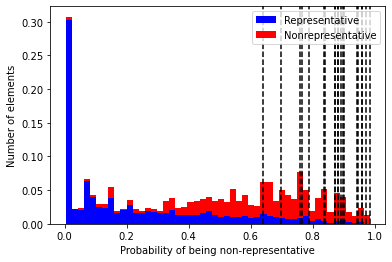

graph auc: 0.7717294035078931
auc 0.865685584876271
graph auc: 0.7599783685166426
auc 0.8615086249688455
graph auc: 0.7543218863517138
auc 0.8517917916884002
graph auc: 0.7032464142711246
auc 0.8375828741132088
graph auc: 0.6737455470913067


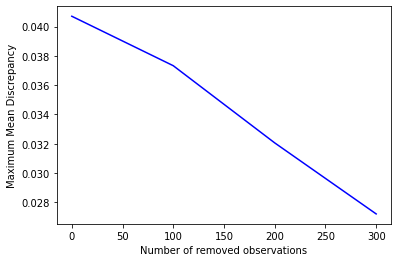

auc 0.8272572673646171


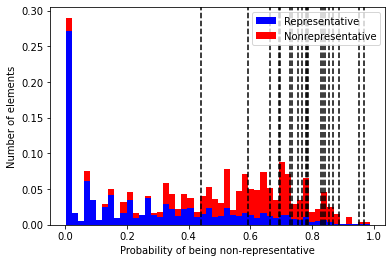

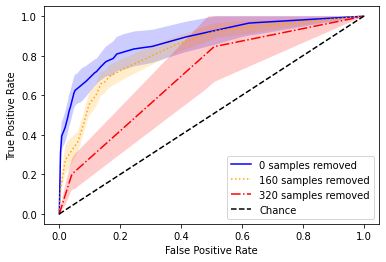

graph auc: 0.6368013286858641
auc 0.8340872392413932
graph auc: 0.6723218704254877
auc 0.8193963433187824
graph auc: 0.6821196022182546
auc 0.8174391825742506
graph auc: 0.6565673062266494
auc 0.8032466403564066
graph auc: 0.6581425156635092


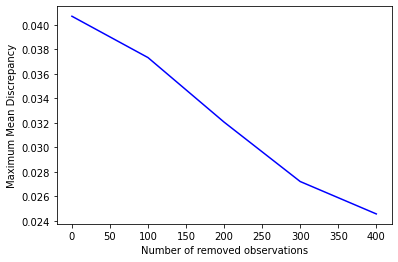

auc 0.7739389222045017


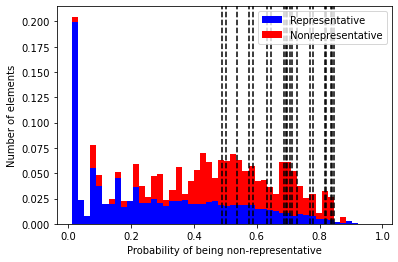

graph auc: 0.6030472961269313
auc 0.7882631651398554
graph auc: 0.545461259415427
auc 0.767329088012245
graph auc: 0.5052203751065644
auc 0.7347729866246333


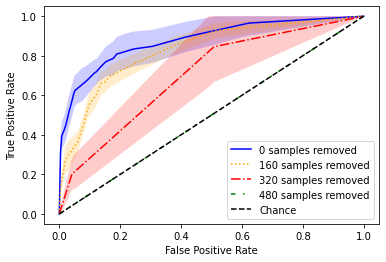

graph auc: 0.5
auc 0.7182949761203468
graph auc: 0.5


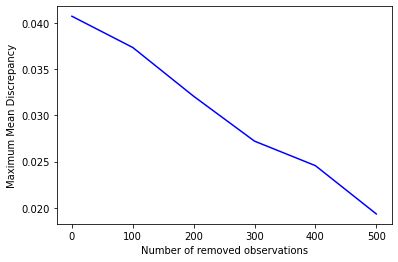

auc 0.648840680308993


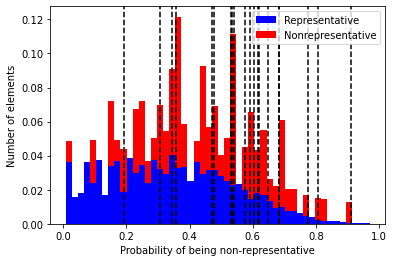

graph auc: 0.5074313725490196
auc 0.6031688413225844
graph auc: 0.5
auc 0.6008170851663437
graph auc: 0.5


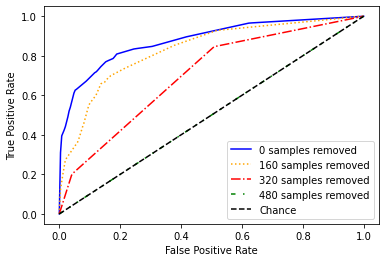

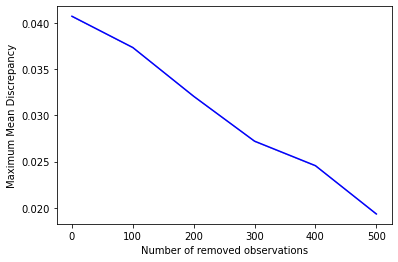

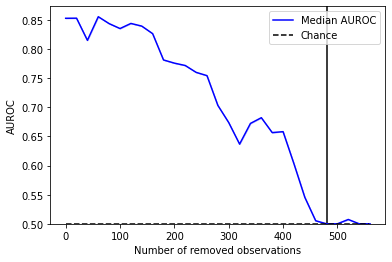

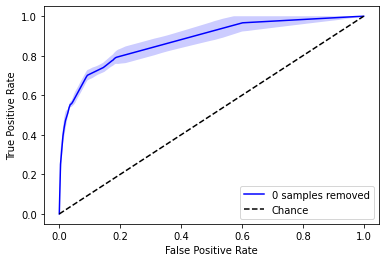

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.9060097854986502


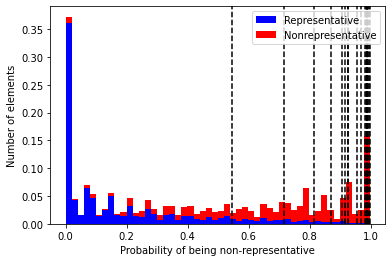

graph auc: 0.8389903100386368
auc 0.9125289292524265
graph auc: 0.8422138485615861
auc 0.9110734775092776
graph auc: 0.8410175093774963
auc 0.9053983460236139
graph auc: 0.8306416299767578
auc 0.896447637567439
graph auc: 0.817862696339772


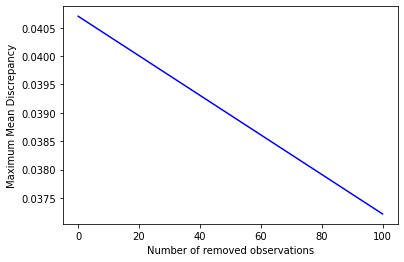

auc 0.8966442306700189


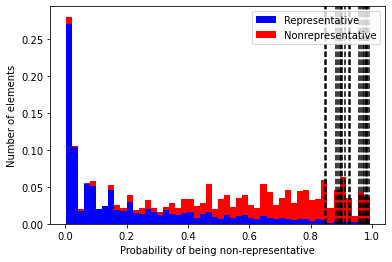

graph auc: 0.8314705715842242
auc 0.8876770184551946
graph auc: 0.8310673840013536
auc 0.8836837396016001


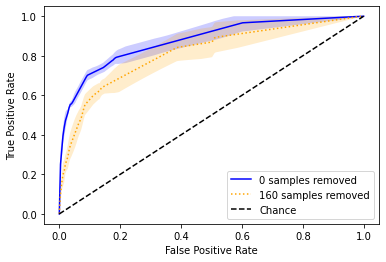

graph auc: 0.8054300071881393
auc 0.8848927530891727
graph auc: 0.817768993809896
auc 0.8793783706146986
graph auc: 0.7940869504461633


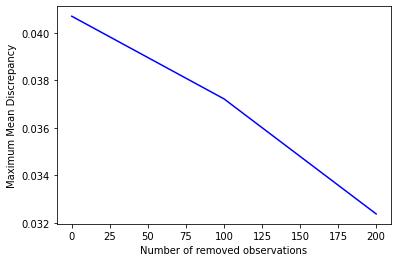

auc 0.8727206339408744


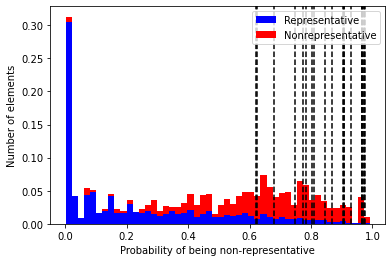

graph auc: 0.7945692992996509
auc 0.8640115878486236
graph auc: 0.7747917459056826
auc 0.8600305746068309
graph auc: 0.7580855036655415
auc 0.8548572372920495
graph auc: 0.7584310022034408
auc 0.8521938272314321
graph auc: 0.7536572786840402


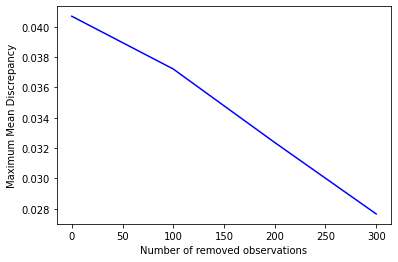

auc 0.8345315912409497


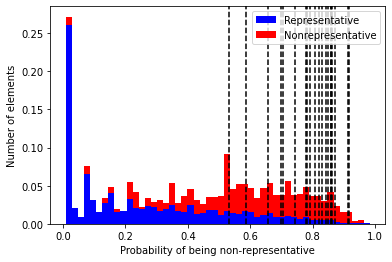

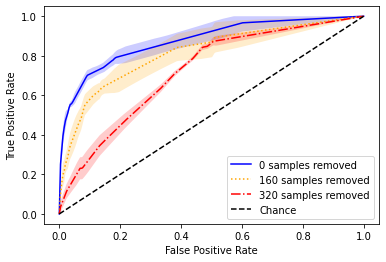

graph auc: 0.7178988802370636
auc 0.8201789019628511
graph auc: 0.7216704232641606
auc 0.8155884082004036
graph auc: 0.6014860092028356
auc 0.8025396252247373
graph auc: 0.6228379061872099
auc 0.8024246911185724
graph auc: 0.5727342360265661


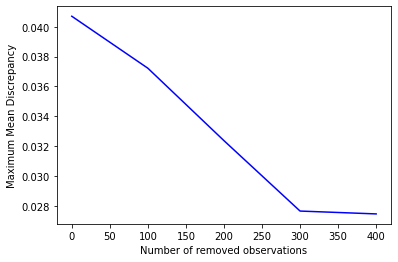

auc 0.7968269891962749


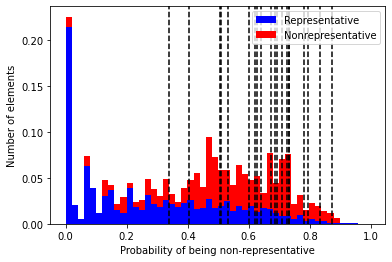

graph auc: 0.503125
auc 0.7847987909844861
graph auc: 0.5071428571428571
auc 0.7478467214460955
graph auc: 0.5083333333333334
auc 0.7303933105367354


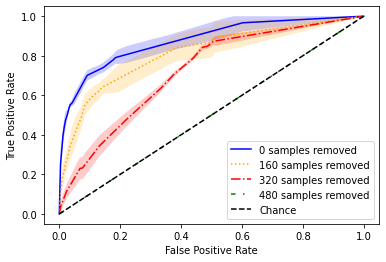

graph auc: 0.5
auc 0.7220189658410417
graph auc: 0.5


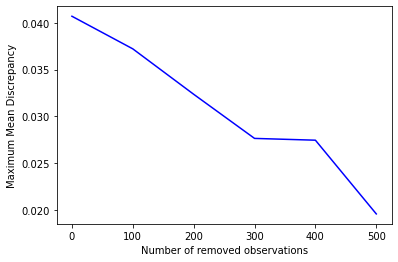

auc 0.6646344188208098


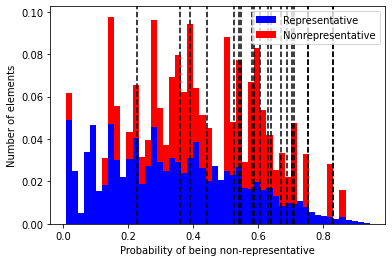

graph auc: 0.5
auc 0.5892373479702102
graph auc: 0.49793277310924366
auc 0.5386727495458962
graph auc: 0.49823529411764705


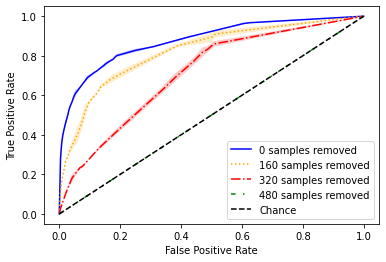

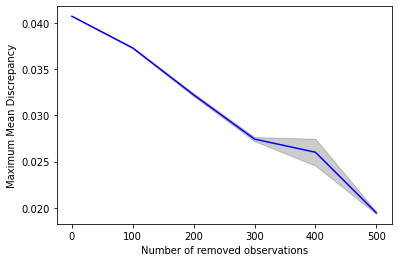

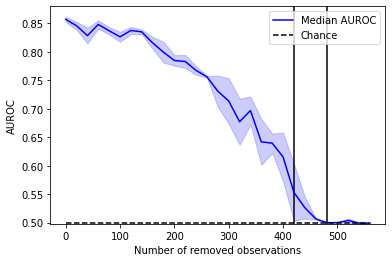

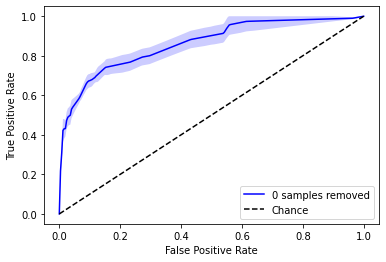

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.9125005944708722


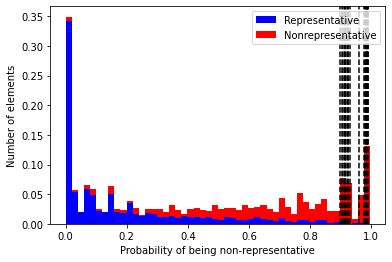

graph auc: 0.8517328118383253
auc 0.9137667244444763
graph auc: 0.8312467153762398
auc 0.9086614726765351
graph auc: 0.8314807956721244
auc 0.8965364626200157
graph auc: 0.8288700465473692
auc 0.9048291923927876
graph auc: 0.8383759464178704


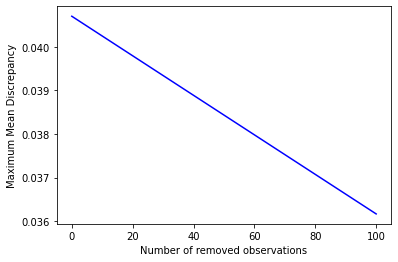

auc 0.9030988993603308


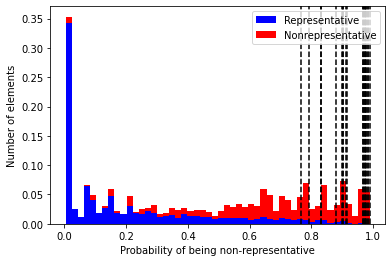

graph auc: 0.8180315173140176
auc 0.8876211293596699
graph auc: 0.8290199847875612
auc 0.8887799407176604


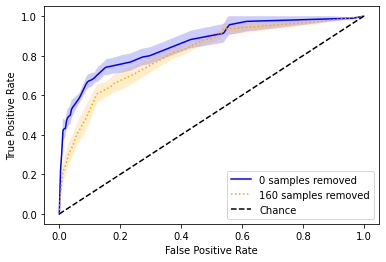

graph auc: 0.8237272078882782
auc 0.8842894944816442
graph auc: 0.8183967669028517
auc 0.8778465344344624
graph auc: 0.7137648300130913


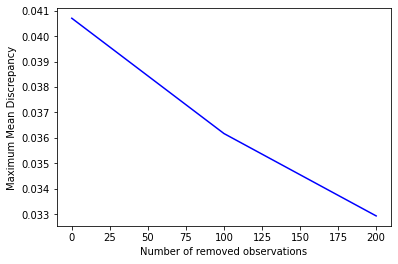

auc 0.8688550650750665


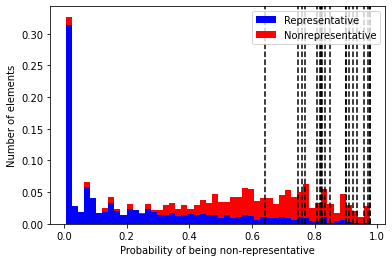

graph auc: 0.7837301479221837
auc 0.8664322786747792
graph auc: 0.7718049986900204
auc 0.8704154578103056
graph auc: 0.7241396075214537
auc 0.8577408219230638
graph auc: 0.705499452016937
auc 0.8237338551427801
graph auc: 0.6704542138731496


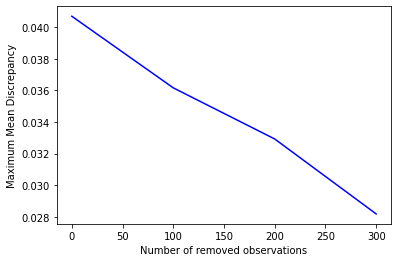

auc 0.8426355431722918


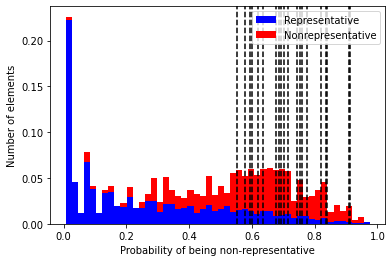

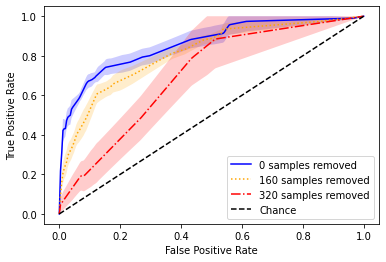

graph auc: 0.6721005095161195
auc 0.8284829226227202
graph auc: 0.6190371855794419
auc 0.8319954190550374
graph auc: 0.6630556804064682
auc 0.8173682553294839
graph auc: 0.5816803332640477
auc 0.7931106461940203
graph auc: 0.5027777777777778


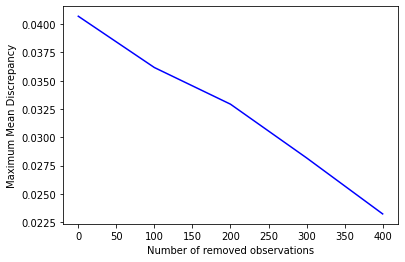

auc 0.8060450635114933


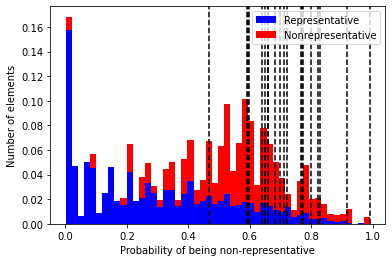

graph auc: 0.5551911764705882
auc 0.7631555186495973
graph auc: 0.5072751322751323
auc 0.74658616246565
graph auc: 0.5
auc 0.7272981680316278


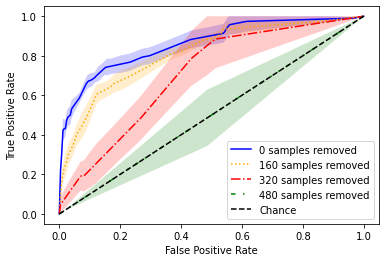

graph auc: 0.5350278637770898
auc 0.7382889854059541
graph auc: 0.5


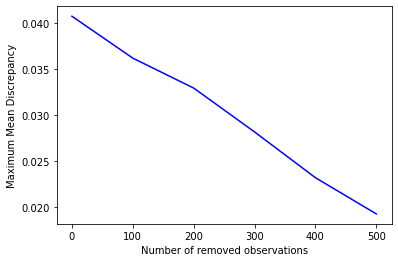

auc 0.698065963398685


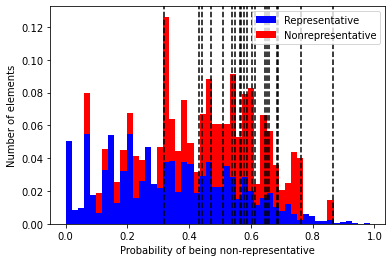

graph auc: 0.5
auc 0.6637214738462888
graph auc: 0.5
auc 0.6057322688294682
graph auc: 0.5


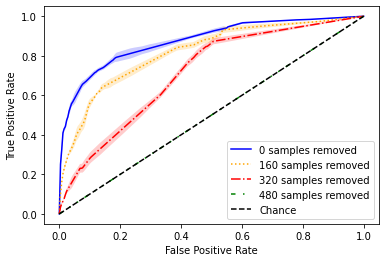

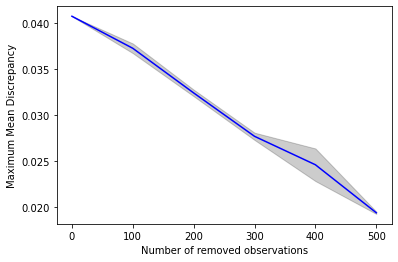

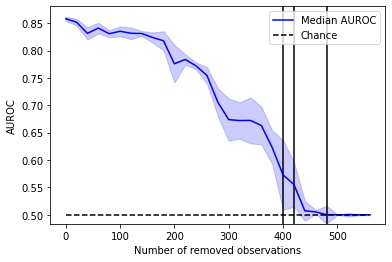

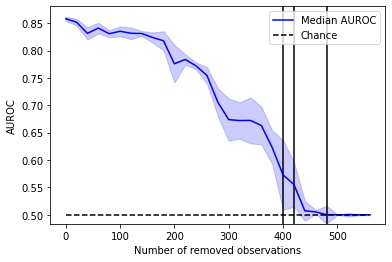

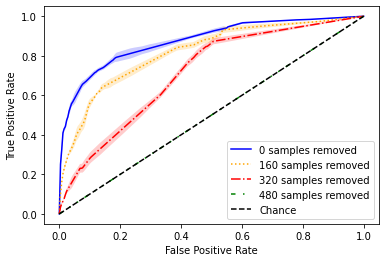

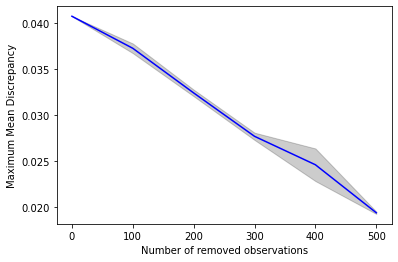

In [58]:
drop = 20
number_of_splits = 5
result_dir_gesis = os.path.join(os.getcwd(), 'results/gbs_gesis',  
                                datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.3
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) / drop) 

os.makedirs(result_dir_gesis, exist_ok=True)
aucs = []
rocs = []
mmds = []
mmd_iteration = 5
mrs_iterations = []

for _ in tqdm(range(3)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_gesis_gbs, gesis_columns, 
                                                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=5, directory=result_dir_gesis,
                                             number_of_iterations=number_of_iterations)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis=0)
    plot_rocs(median_rocs, '', save=False)
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iterations)
    

plot_auc_median(median_aucs, std_aucs, drop, result_dir_gesis + "/median_aucs", save=True,
               mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_gesis + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_gesis + "/median_mmds", save=True)

pickle.dump(median_aucs, open(result_dir_gesis + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_gesis + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_gesis + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_gesis + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_gesis + "/std_mmds", 'wb'))
pickle.dump(mrs_iterations, open(result_dir_gesis + "/mrs_iterations", 'wb'))

### Save results

In [59]:
pickle.dump(median_aucs, open("results/gesis_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/gesis_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/gesis_median_rocs", 'wb'))
pickle.dump(median_mmds, open("results/gesis_median_mmds", 'wb'))
pickle.dump(std_mmds, open("results/gesis_std_mmds", 'wb'))
pickle.dump(mrs_iterations, open("results/gesis_mrs_iterations", 'wb'))

### Load results

In [60]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_rocs =  pickle.load(open("results/gesis_median_rocs", 'rb'))
gesis_mrs_iterations =  pickle.load(open("results/gesis_mrs_iterations", 'rb'))
gesis_median_mmds =  pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds =  pickle.load(open("results/gesis_std_mmds", 'rb'))

### Visualise results

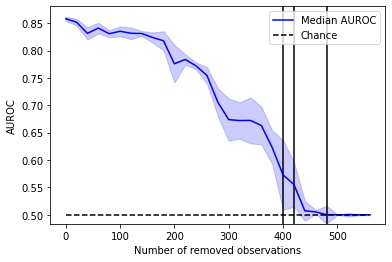

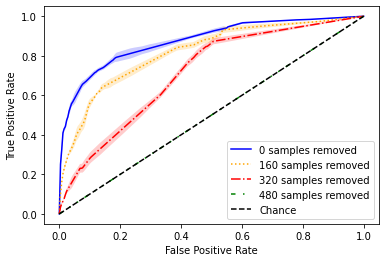

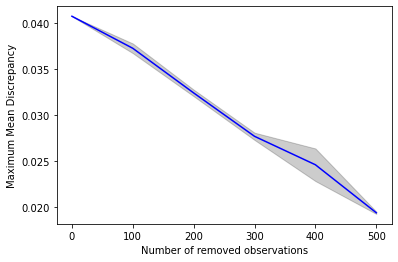

In [61]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/gesis/")
os.makedirs(file_directory, exist_ok=True)

plot_auc_median(gesis_median_aucs, gesis_std_aucs, drop, file_directory+"gesis_auc", save=save, 
                mrs_iteration=gesis_mrs_iterations)
plot_rocs(gesis_median_rocs, file_directory+"gesis_rocs", save=save)
plot_mmds_median(gesis_median_mmds, gesis_std_mmds, drop, mmd_iteration, 
                 file_directory + "median_mmds", save=save)

### Experiment 2 c)
### <font color='darkgreen'> Comparison with a third independent dataset (Allensbach) </font>

In [23]:
def repeated_MRS_with_third_dataset(df, columns, comparing_dataset, comparing_dataset_columns,
                                    number_of_splits, number_of_iterations,
                                    n_drop=1, test_size=0.33, cv=5, directory=''):

    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    C = comparing_dataset.copy()
    aucs = []
    comparison_aucs = []
    mmds = []
    comparison_mmds = []
    mmd_iteration = 5

    #start value
    auc, _ = auc_prediction(N, R, columns, test_size, drop, 0, cv, calculate_roc=False)
    aucs.append(auc)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    # start value checking
    auc, _ = auc_prediction(N, C, comparing_dataset_columns, test_size, drop, 0, cv, calculate_roc=False)
    comparison_aucs.append(auc)
    comparison_mmds.append(maximum_mean_discrepancy(N[comparing_dataset_columns],
                                                     C[comparing_dataset_columns]))
    
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS_with_histogram(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv, directory=directory, iteration=i)
        
        # auc
        auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
        aucs.append(auc)
        
        # auc check
        auc, _ = auc_prediction(N, C, comparing_dataset_columns, test_size, drop, i+1, cv, 
                                calculate_roc=False)
        comparison_aucs.append(auc)
        
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            comparison_mmds.append(maximum_mean_discrepancy(N[comparing_dataset_columns],
                                                             C[comparing_dataset_columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            plot_mmds(comparison_mmds, drop, mmd_iteration, '', False)
           
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    return aucs, comparison_aucs, mmds, comparison_mmds

In [37]:
gesis_columns = ['Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung',  
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

allensbach_columns = ['Alter', 'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']

all_columns = ['Erwerbstaetigkeit', 'Geschlecht']

allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gbs['label'] = 1
gesis['label'] = 0
gesis_gbs = pd.concat([gbs, gesis])

In [38]:
# create scaler
scaled_allensbach_gbs = allensbach.copy(deep=True)
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_checking = gesis.copy(deep=True)
scaled_allensbach_checking = allensbach[allensbach['label']==0].copy(deep=True)

# create scaler
scaler_allensbach = StandardScaler()
all_scaler = StandardScaler()
scaler_gesis = StandardScaler()

# fit scaler
scaler_allensbach = scaler_allensbach.fit(allensbach[allensbach_columns])
all_scaler = all_scaler.fit(pd.concat([scaled_allensbach_checking[all_columns], 
                                       gesis[all_columns], gbs[all_columns]]))
scaler_gesis = scaler_gesis.fit(gesis_gbs[gesis_columns])



# transform datasets
scaled_allensbach_gbs[all_columns] = all_scaler.transform(scaled_allensbach_gbs[all_columns])
scaled_allensbach_gbs[allensbach_columns] = scaler_allensbach.transform(
    scaled_allensbach_gbs[allensbach_columns])
scaled_allensbach_gbs[gesis_columns] = scaler_gesis.transform(scaled_allensbach_gbs[gesis_columns])

scaled_allensbach_checking[all_columns] = all_scaler.transform(scaled_allensbach_checking[all_columns])
scaled_allensbach_checking[allensbach_columns] = scaler_allensbach.transform(
    scaled_allensbach_checking[allensbach_columns])

scaled_gesis_checking[all_columns] = all_scaler.transform(scaled_gesis_checking[all_columns])
scaled_gesis_checking[gesis_columns] = scaler_gesis.transform(scaled_gesis_checking[gesis_columns])

scaled_gesis_gbs[gesis_columns] = scaler_gesis.transform(scaled_gesis_gbs[gesis_columns])
scaled_gesis_gbs[all_columns] = all_scaler.transform(scaled_gesis_gbs[all_columns])
scaled_gesis_gbs[allensbach_columns] = scaler_allensbach.transform(scaled_gesis_gbs[allensbach_columns])

### Create with allensbach

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

auc 0.8468570474895576


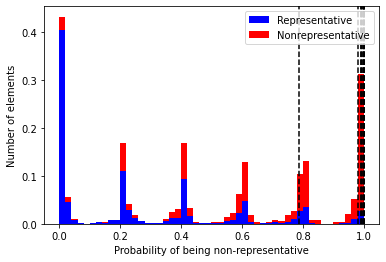

auc 0.8153216106395443
auc 0.8309259188774281
auc 0.8273618054748155
auc 0.8117483453729655


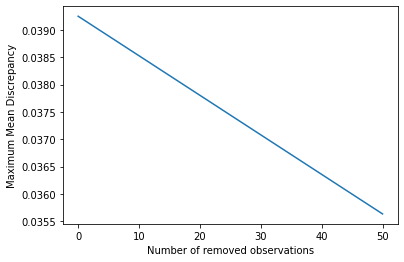

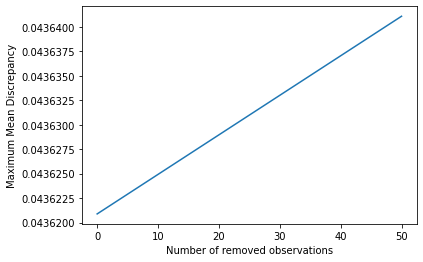

auc 0.8302103862499832


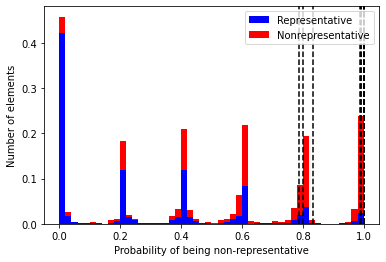

auc 0.8224106300987988
auc 0.8308418328247571
auc 0.8173403544678008
auc 0.8002826364414278


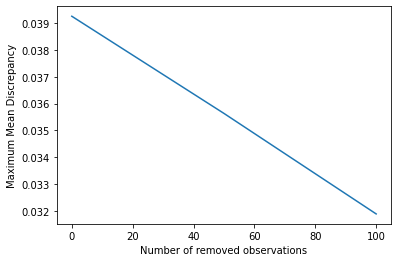

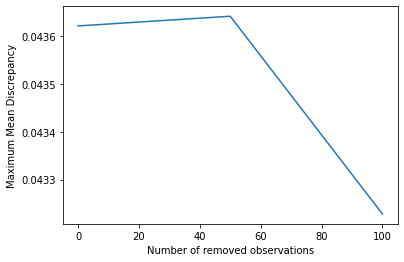

auc 0.8285749714979493


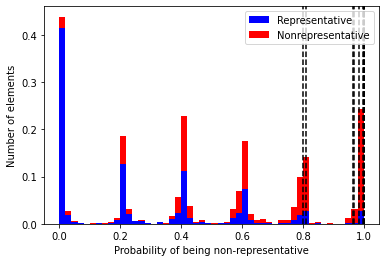

auc 0.8160470444131924
auc 0.8107762017336485
auc 0.8071897360564848
auc 0.8033217418698202


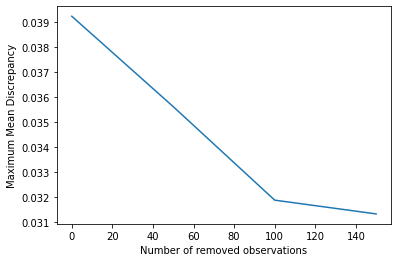

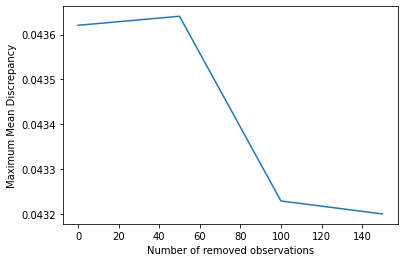

auc 0.7894245234670765


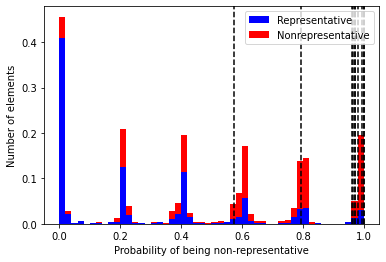

auc 0.7896979045007533
auc 0.7981953042362447
auc 0.7830580440462859
auc 0.7895244215938304


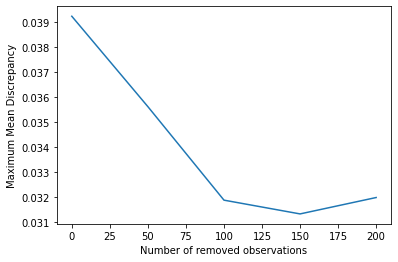

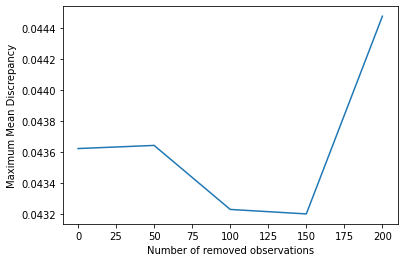

auc 0.7841101536331144


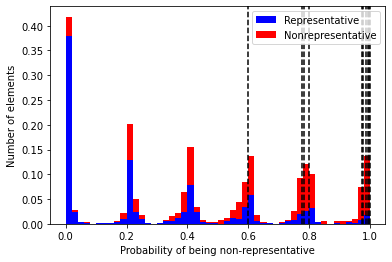

auc 0.7794943685252455
auc 0.769371431675853
auc 0.7707672885041353
auc 0.7587227243247767


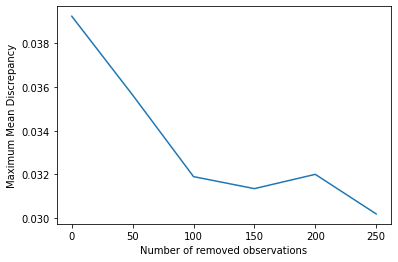

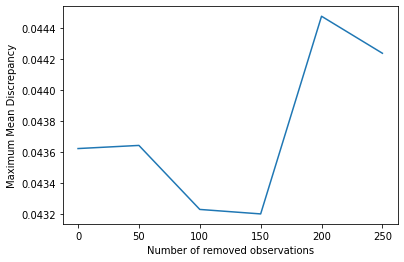

auc 0.7705436633684709


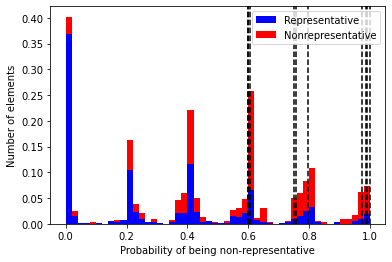

auc 0.7689282776406767
auc 0.7568325529619684
auc 0.7465309898242369
auc 0.7500337431593413


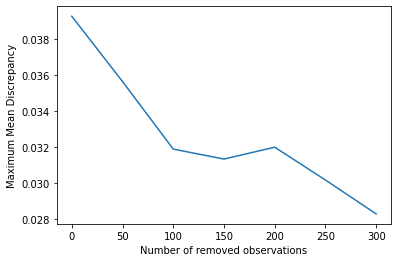

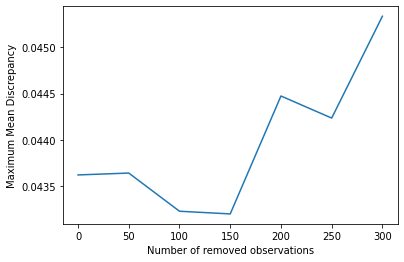

auc 0.7487432954574341


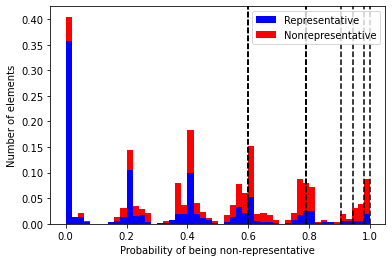

auc 0.7329170950987371
auc 0.7478350310797118
auc 0.7401218348571591
auc 0.7486127184782931


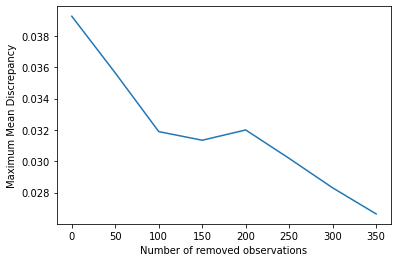

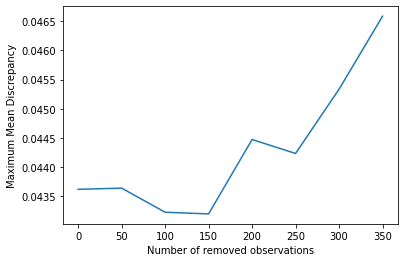

auc 0.7246430672984607


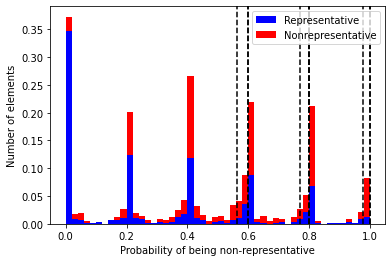

auc 0.7095821593963534
auc 0.722443499949099
auc 0.6946389750169285
auc 0.7088891703253405


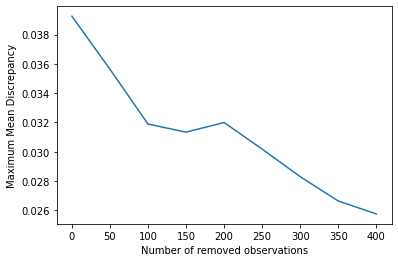

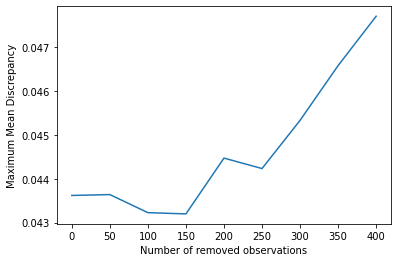

auc 0.7184887475732001


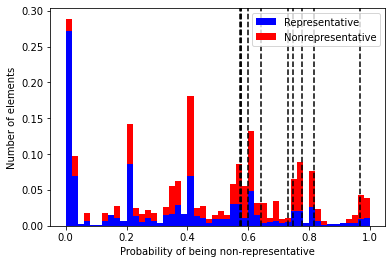

auc 0.7317423097905913
auc 0.7169783442615638
auc 0.6905433385691847
auc 0.6775409459666311


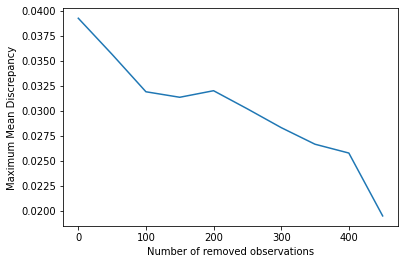

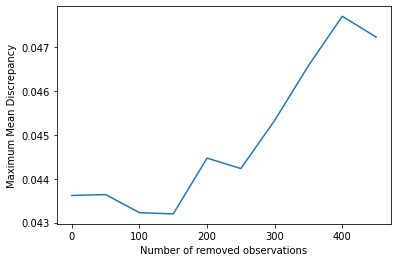

auc 0.6742261806586398


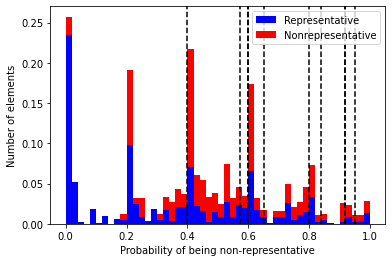

auc 0.6928824721377914
auc 0.6332308543171319
auc 0.6919773980944194
auc 0.6788090684516694


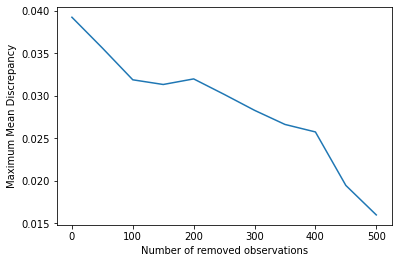

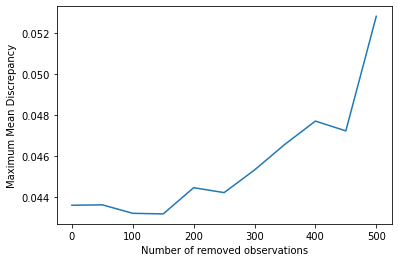

auc 0.6371925217703562


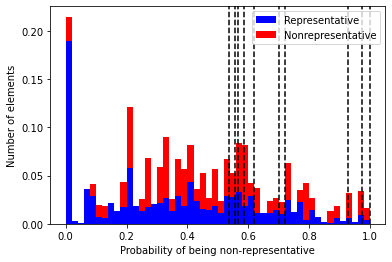

auc 0.5918131359851988
auc 0.5880815001803101
auc 0.596396005210595
auc 0.6011661211129296


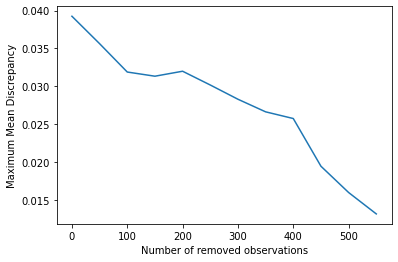

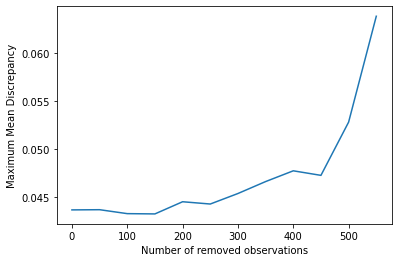

auc 0.46777940816825636


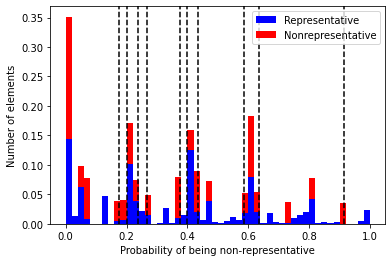

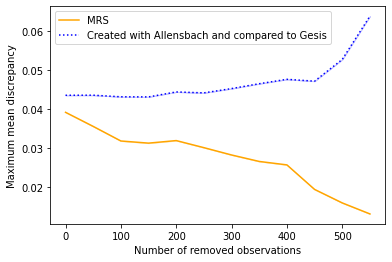

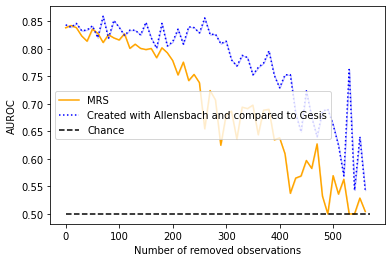

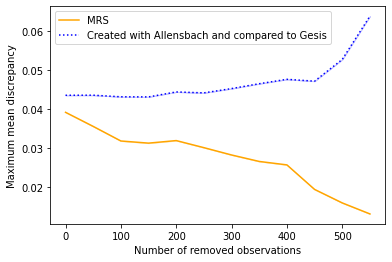

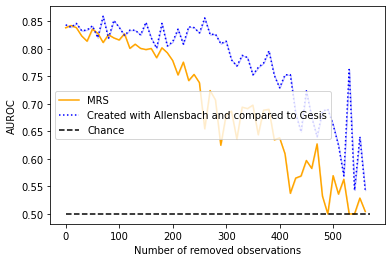

In [68]:
drop = 20
number_of_splits = 5
cv = 5
test_size = 0.3
mmd_iteration = 5
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) / drop) 

result_dir_allensbach = os.path.join(os.getcwd(), 'results/third_dataset_test/gbs_allensbach_gesis_check', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_allensbach, exist_ok=True)

aucs = []
aucs_checking = []
mmds = []
mmds_checking = []

#calculate mrs with allensbach
for _ in tqdm(range(3)):
    auc, auc_checking, mmd, mmd_checking = repeated_MRS_with_third_dataset(scaled_allensbach_gbs, 
                      allensbach_columns+all_columns, comparing_dataset=scaled_gesis_checking, 
                      comparing_dataset_columns=gesis_columns+all_columns, 
                      number_of_iterations=number_of_iterations, 
                      number_of_splits=number_of_splits, n_drop=drop, test_size=test_size, cv=cv,
                                                                          directory=result_dir_allensbach)
    
    
    # allensbach
    aucs.append(auc)
    mmds.append(mmd)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    # gesis checking
    aucs_checking.append(auc_checking)
    mmds_checking.append(mmd_checking)
    median_mmds_checking = np.median(mmds_checking, axis = 0)
    std_mmds_checking = np.std(mmds_checking, axis = 0)
    median_aucs_checking = np.median(aucs_checking, axis = 0)
    std_aucs_checking = np.std(aucs_checking, axis = 0)
    
    plot_experiment_comparison_mmd(median_mmds, std_mmds,  median_mmds_checking, std_mmds_checking, 
                               "Created with Allensbach and compared to Gesis", drop, mmd_iteration, '', 
                                   save=False)
    plot_experiment_comparison_auc(median_aucs, std_aucs, median_aucs_checking, std_aucs_checking, 
                               "Created with Allensbach and compared to Gesis", drop, '',  save=False)
    
plot_experiment_comparison_mmd(median_mmds, std_mmds,  median_mmds_checking, std_mmds_checking, 
                               "Created with Allensbach and compared to Gesis", drop, mmd_iteration, 
                               result_dir_allensbach + "/mmds", save=True)
plot_experiment_comparison_auc(median_aucs, std_aucs, median_aucs_checking, std_aucs_checking, 
                               "Created with Allensbach and compared to Gesis", drop, 
                               result_dir_allensbach + "/aucs",  save=True)

### Save results

In [35]:
pickle.dump(median_aucs, open("results/allensbach_median_third_aucs", 'wb'))
pickle.dump(std_aucs, open("results/allenbach_std_third_aucs", 'wb'))
pickle.dump(median_mmds, open("results/allensbach_median_third_mmds", 'wb'))
pickle.dump(std_mmds, open("results/allenbach_std_third_mmds", 'wb'))

pickle.dump(median_aucs_checking, open("results/gesis_median_checking_aucs", 'wb'))
pickle.dump(std_aucs_checking, open("results/gesis_std_checking_aucs", 'wb'))
pickle.dump(median_mmds_checking, open("results/gesis_median_checking_mmds", 'wb'))
pickle.dump(std_mmds_checking, open("results/gesis_std_checking_mmds", 'wb'))

### Load  results

In [99]:
allensbach_median_comparison_aucs = pickle.load(open("results/allensbach_median_third_aucs", 'rb'))
allenbach_std_comparison_aucs = pickle.load(open("results/allenbach_std_third_aucs", 'rb'))
allensbach_median_third_mmds = pickle.load(open("results/allensbach_median_third_mmds", 'rb'))
allenbach_std_third_mmds = pickle.load(open("results/allenbach_std_third_mmds", 'rb'))

gesis_median_comparison_aucs = pickle.load(open("results/gesis_median_checking_aucs", 'rb'))
gesis_std_comparison_aucs = pickle.load(open("results/gesis_std_checking_aucs", 'rb'))
gesis_median_checking_mmds = pickle.load(open("results/gesis_median_checking_mmds", 'rb'))
gesis_std_checking_mmds = pickle.load(open("results/gesis_std_checking_mmds", 'rb'))

### Visualise results

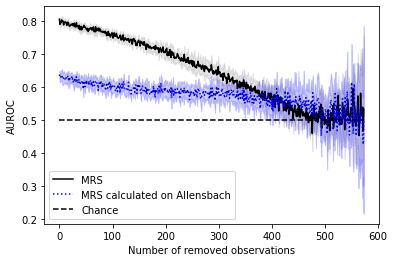

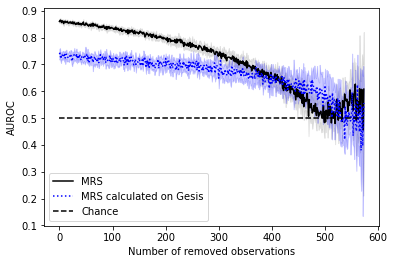

In [101]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/third_dataset/calculated_on_allensbach/")
os.makedirs(file_directory, exist_ok=True)

experiment_label = 'MRS calculated on Allensbach'

plot_experiment_comparison_mmd(allensbach_median_third_mmds, allenbach_std_third_mmds,  
                               gesis_median_checking_mmds, gesis_std_checking_mmds, 
                               "Created with Allensbach and compared to Gesis", drop, mmd_iteration, 
                               file_directory + "mmds", save=save)
plot_experiment_comparison_auc(allensbach_median_comparison_aucs, allenbach_std_comparison_aucs,
                               gesis_median_comparison_aucs, gesis_std_comparison_aucs, 
                               "Created with Allensbach and compared to Gesis", drop, 
                               file_directory + "aucs",  save=save)

### Create with gesis

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

auc 0.8902710421348761


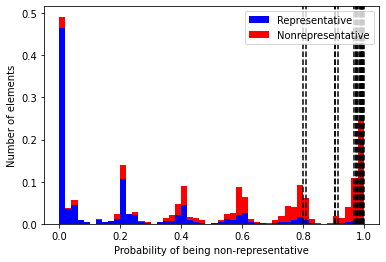

auc 0.8853085920248097
auc 0.8817549998668245
auc 0.8754187203063987
auc 0.8800717462224991


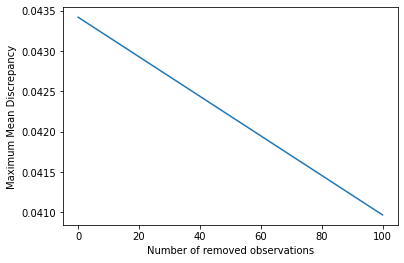

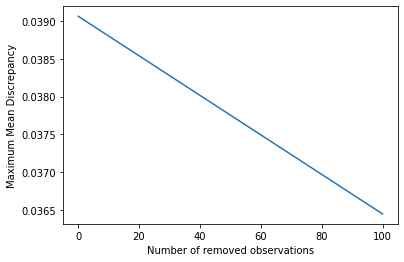

auc 0.8790718778973413


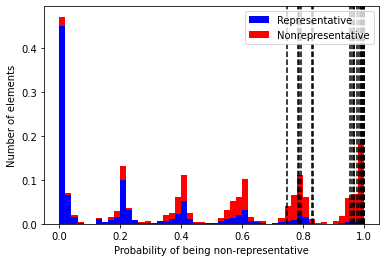

auc 0.8687136945204588
auc 0.8562363059028764
auc 0.8588037842401216
auc 0.8582674030333541


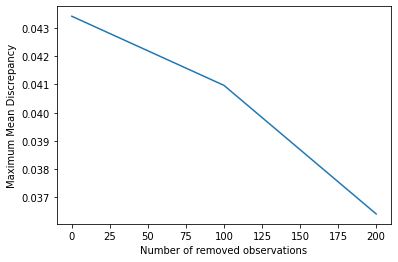

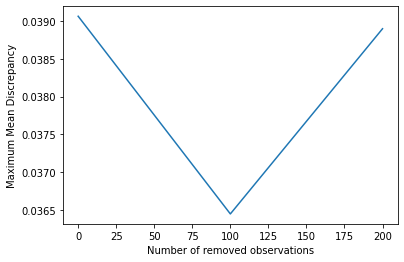

auc 0.8403051222358078


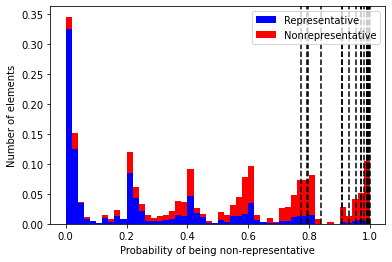

auc 0.8332093214133294
auc 0.8400772418427795
auc 0.8179863084140764
auc 0.8013937570201448


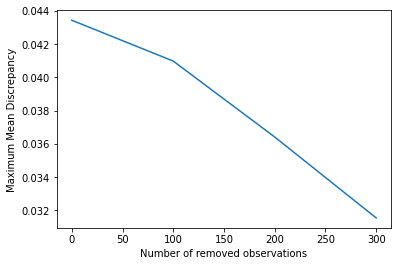

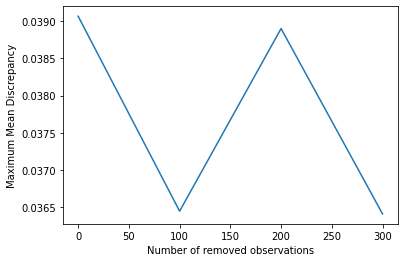

auc 0.8070526398368243


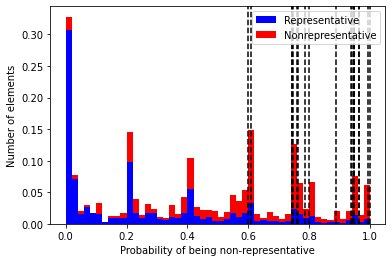

auc 0.7774806881655552
auc 0.8119119339918525
auc 0.7813930970596359
auc 0.7816145921416922


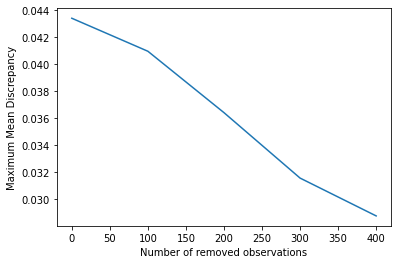

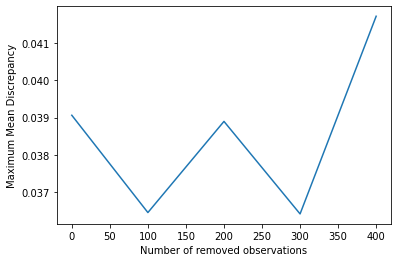

auc 0.7713034023122102


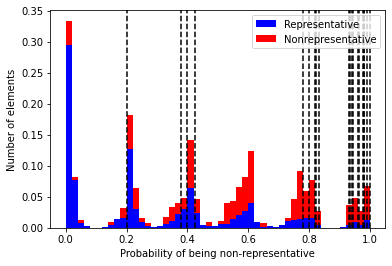

auc 0.7503511740091268
auc 0.6903096962298366
auc 0.7275048404864417
auc 0.6912654433247514


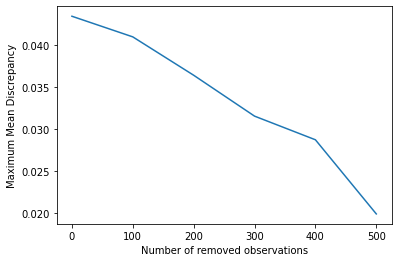

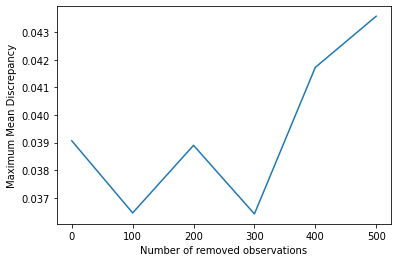

auc 0.6106723547759562


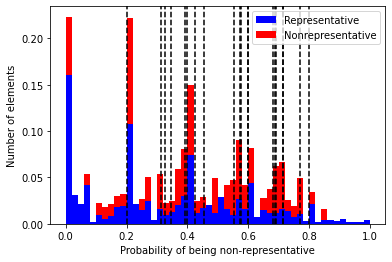

auc 0.5916167712442807


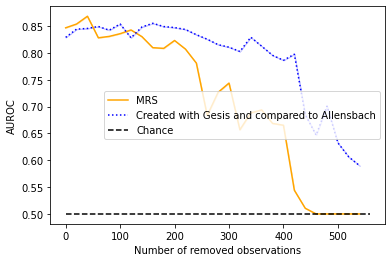

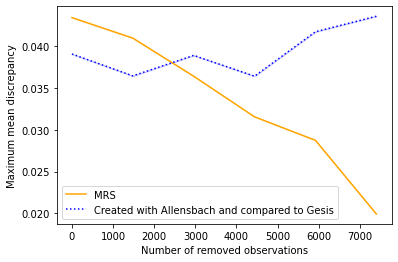

  0%|          | 0/27 [00:00<?, ?it/s]

auc 0.8966395018882833


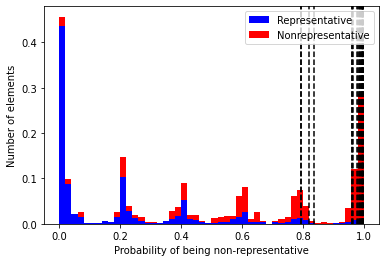

auc 0.8775403746477652
auc 0.8793938637095011
auc 0.8854090569196604
auc 0.876013264467273


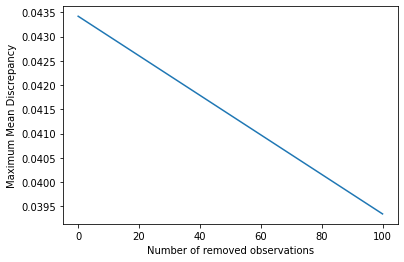

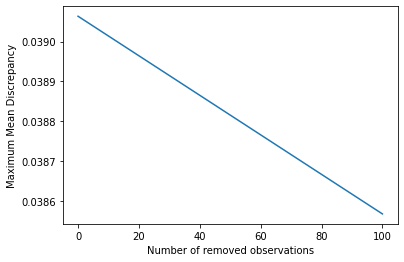

auc 0.8749080589267966


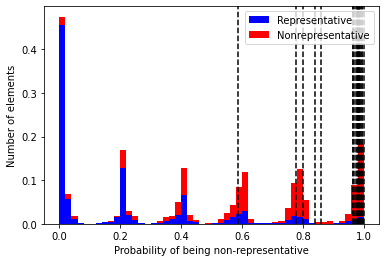

auc 0.8653916261727095
auc 0.8594033381028685
auc 0.8580525194472264
auc 0.8495520986509577


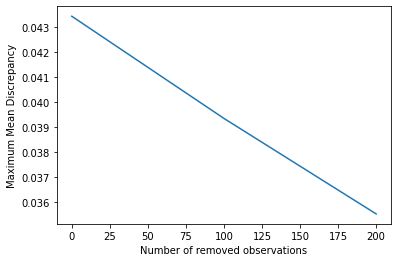

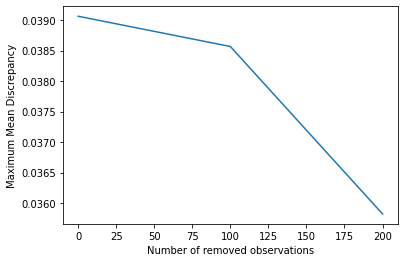

auc 0.851399460124406


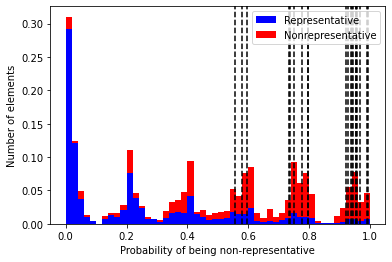

auc 0.8483080731432139
auc 0.8204123684142929
auc 0.8404300919781237
auc 0.8245933924252097


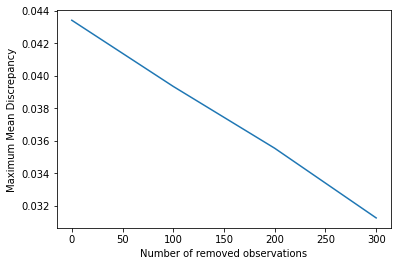

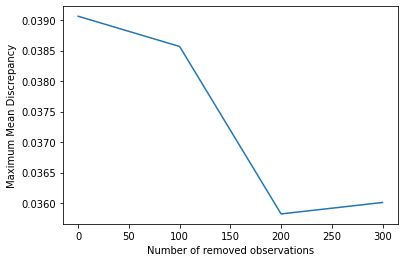

auc 0.8144842851491096


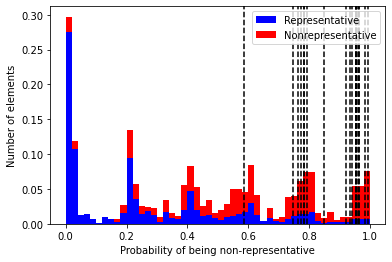

auc 0.8206073470841652
auc 0.7966132321560278
auc 0.7737990459210925
auc 0.7500014783259674


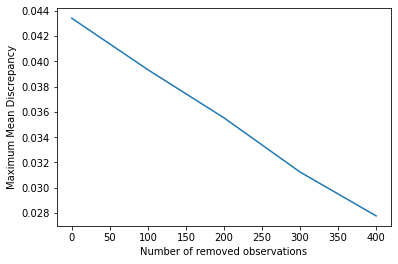

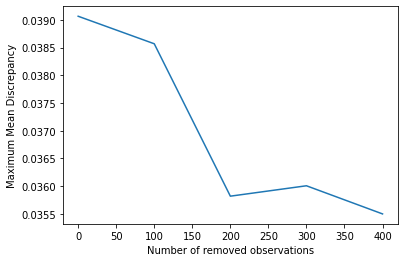

auc 0.7453945785469076


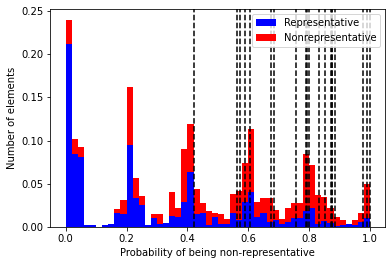

auc 0.73853559328055
auc 0.7379366452707449
auc 0.7052583801230542
auc 0.611786255114097


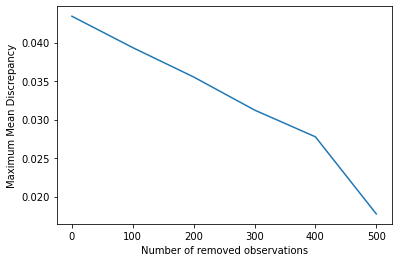

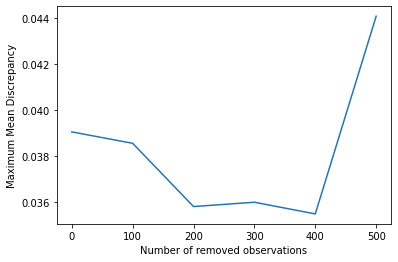

auc 0.6523977346866425


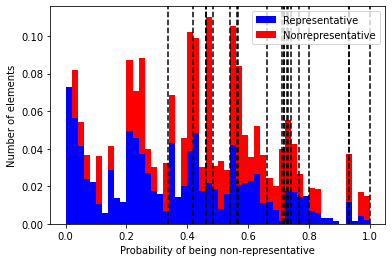

auc 0.5949714987773794


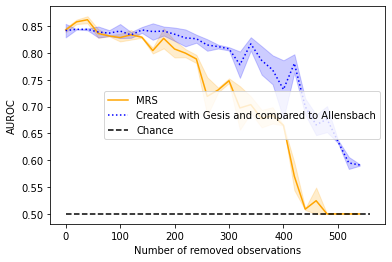

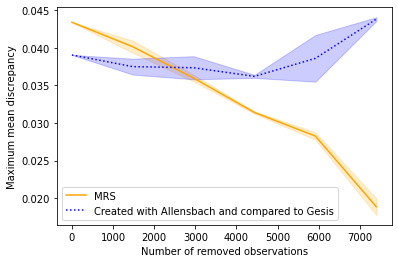

  0%|          | 0/27 [00:00<?, ?it/s]

auc 0.8841808150734237


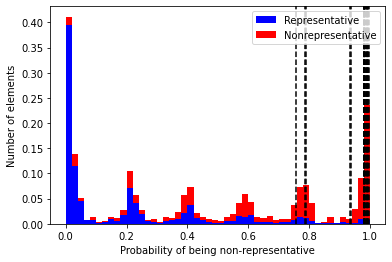

auc 0.8930812300989688
auc 0.8862794738126748
auc 0.8712327642773023
auc 0.8783603922365797


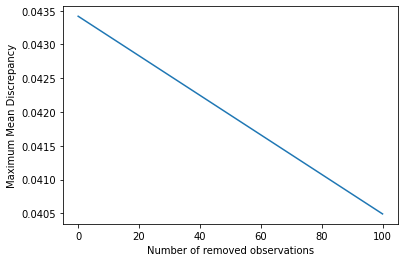

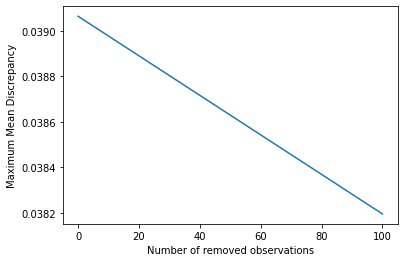

auc 0.8762132905151206


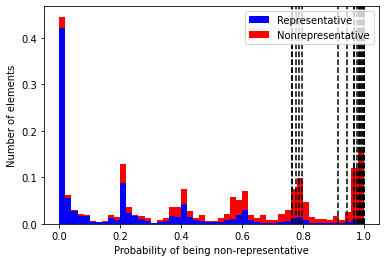

auc 0.8606679721128795
auc 0.8505672780571175
auc 0.852058128516551
auc 0.8525653389770023


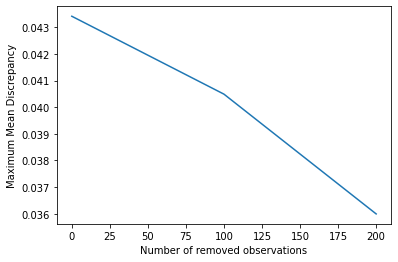

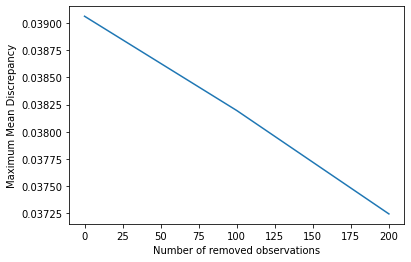

auc 0.8628965002474585


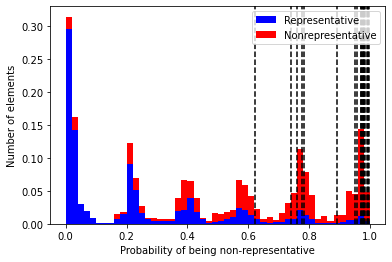

auc 0.8281988027987578
auc 0.8190613651242598
auc 0.8316520722928722
auc 0.8203905542205091


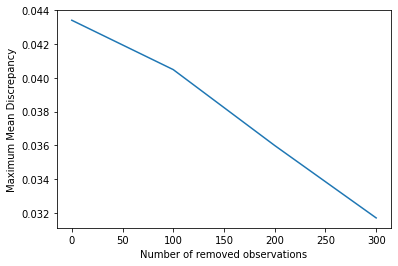

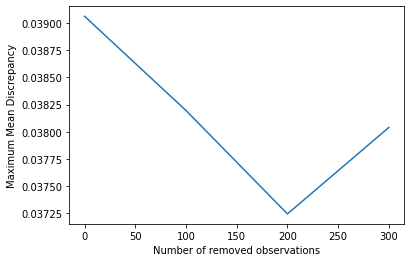

auc 0.8167627044440565


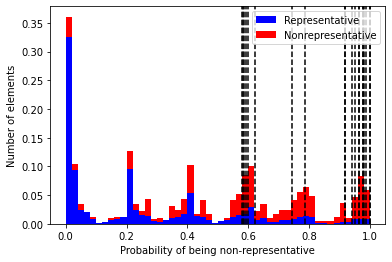

auc 0.794199589092505
auc 0.7820141780837431
auc 0.7639793838141876
auc 0.7833921312848072


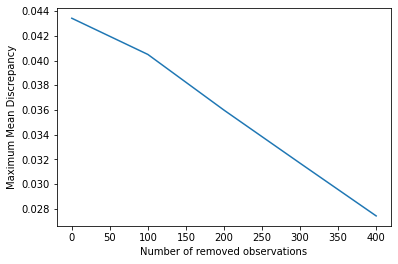

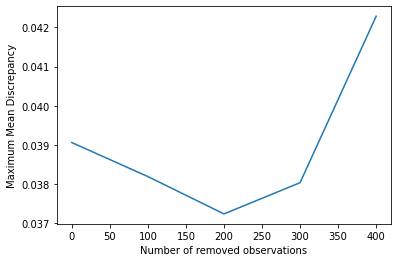

auc 0.7392965285292235


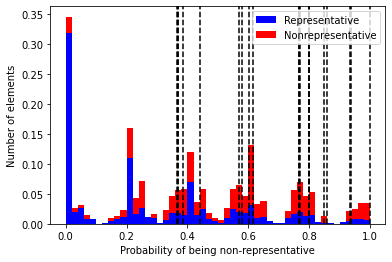

auc 0.7311043219936323
auc 0.745364546207233
auc 0.7405519044520609
auc 0.6829271771611145


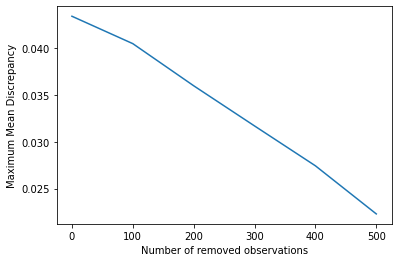

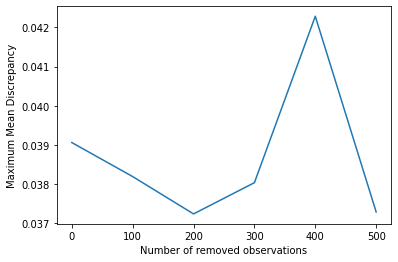

auc 0.6681989209672566


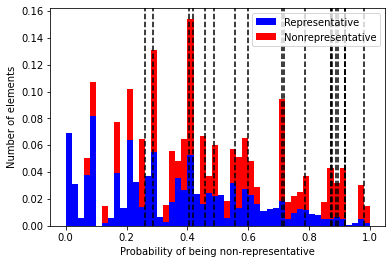

auc 0.6268015205970697


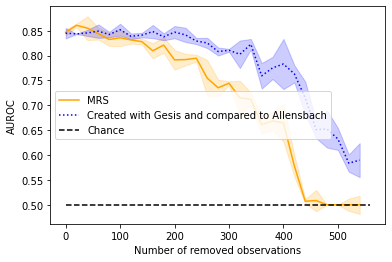

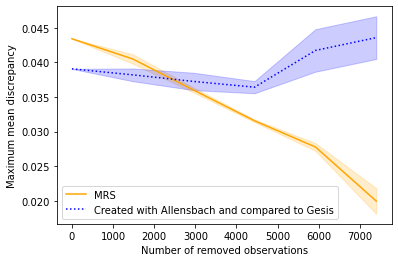

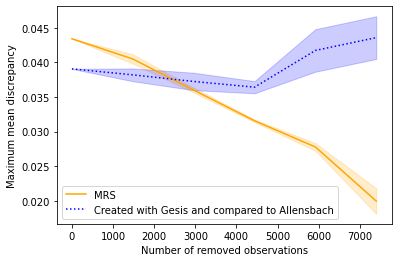

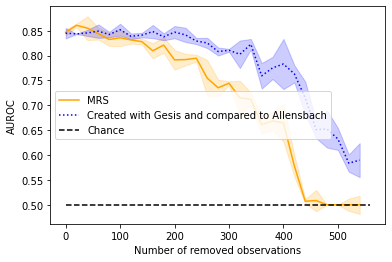

In [44]:
drop = 20
number_of_splits = 5
cv = 5
test_size = 0.3
mmd_iteration = 5
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) / drop) 
aucs = []
aucs_checking = []
mmds = []
mmds_checking = []

result_dir_gesis = os.path.join(os.getcwd(), 'results/third_dataset_test/gbs_gesis_allensbach_check', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_gesis, exist_ok=True)

# calculate mrs with gesis
for temp in tqdm(range(3)):
    auc, auc_checking, mmd, mmd_checking = repeated_MRS_with_third_dataset(scaled_gesis_gbs, 
                      gesis_columns + all_columns, scaled_allensbach_checking, 
                        allensbach_columns+all_columns, 
                      number_of_iterations=number_of_iterations, 
                      number_of_splits=number_of_splits, n_drop=drop, test_size=test_size, cv=cv,
                                                                          directory=result_dir_gesis)
    
    # allensbach
    mmds.append(mmd)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    aucs.append(auc)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    # gesis checking
    mmds_checking.append(mmd_checking)
    median_mmds_checking = np.median(mmds_checking, axis = 0)
    std_mmds_checking = np.std(mmds_checking, axis = 0)
    aucs_checking.append(auc_checking)
    median_aucs_checking = np.median(aucs_checking, axis = 0)
    std_aucs_checking = np.std(aucs_checking, axis = 0)
    
    plot_experiment_comparison_auc(median_aucs, std_aucs, median_aucs_checking, std_aucs_checking, 
                               "Created with Gesis and compared to Allensbach", drop, '',  save=False)
    plot_experiment_comparison_mmd(median_mmds, std_mmds,  median_mmds_checking, std_mmds_checking, 
                               "Created with Allensbach and compared to Gesis", drop, mrs_iteration, '', 
                                   save=False)
    
plot_experiment_comparison_mmd(median_mmds, std_mmds,  median_mmds_checking, std_mmds_checking, 
                               "Comparing to Allensbach", drop, mrs_iteration, 
                               result_dir_gesis + "/mmds", save=True)
plot_experiment_comparison_auc(median_aucs, std_aucs, median_aucs_checking, std_aucs_checking, 
                               "Comparing to Allensbach", drop, 
                               result_dir_gesis + "/aucs",  save=True)

### Save results

In [35]:
pickle.dump(median_aucs, open("results/gesis_median_third_aucs", 'wb'))
pickle.dump(std_aucs, open("results/gesis_std_third_aucs", 'wb'))
pickle.dump(median_mmds, open("results/gesis_median_third_mmds", 'wb'))
pickle.dump(std_mmds, open("results/gesis_std_third_mmds", 'wb'))

pickle.dump(median_aucs_checking, open("results/allensbach_median_checking_aucs", 'wb'))
pickle.dump(std_aucs_checking, open("results/allensbach_std_checking_aucs", 'wb'))
pickle.dump(median_mmds_checking, open("results/allensbach_median_checking_mmds", 'wb'))
pickle.dump(std_mmds_checking, open("results/allensbach_std_checking_mmds", 'wb'))

### Load  results

In [99]:
gesis_median_comparison_aucs = pickle.load(open("results/gesis_median_third_aucs", 'rb'))
gesis_std_comparison_aucs = pickle.load(open("results/gesis_std_third_aucs", 'rb'))
gesis_median_third_mmds = pickle.load(open("results/gesis_median_third_mmds", 'rb'))
gesis_std_third_mmds = pickle.load(open("results/gesis_std_third_mmds", 'rb'))

allensbach_median_comparison_aucs = pickle.load(open("results/allensbach_median_checking_aucs", 'rb'))
allensbach_std_comparison_aucs = pickle.load(open("results/allensbach_std_checking_aucs", 'rb'))
allensbach_median_checking_mmds = pickle.load(open("results/allensbach_median_checking_mmds", 'rb'))
allensbach_std_checking_mmds = pickle.load(open("results/allensbach_std_checking_mmds", 'rb'))

### Visualise results

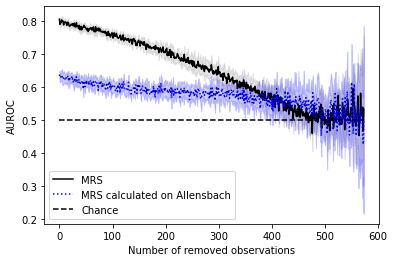

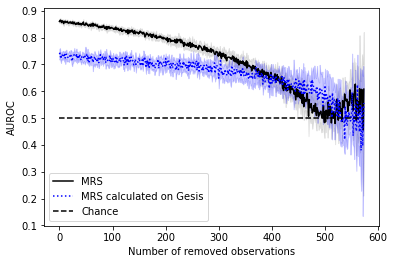

In [101]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/third_dataset/calculated_on_gesis/")
os.makedirs(file_directory, exist_ok=True)

experiment_label = 'MRS calculated on Gesis'

plot_experiment_comparison_mmd(gesis_median_third_mmds, gesis_std_third_mmds,  
                               allensbach_median_checking_mmds, allensbach_std_checking_mmds, 
                               "Comparing to Gesis", drop, mmd_iteration, 
                               file_directory + "mmds", save=save)
plot_experiment_comparison_auc(gesis_median_comparison_aucs, gesis_std_comparison_aucs,
                               allensbach_median_comparison_aucs, allensbach_std_comparison_aucs, 
                               "Comparing to Gesis", drop, 
                               file_directory + "aucs",  save=save)

# Compare MRS with temperature sampling and without 

### Run experiment

  0%|          | 0/3 [00:00<?, ?it/s]

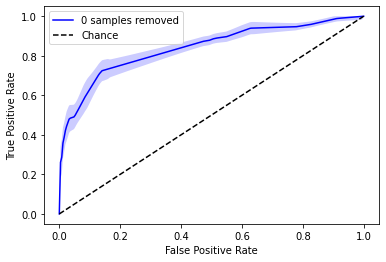

  0%|          | 0/28 [00:00<?, ?it/s]

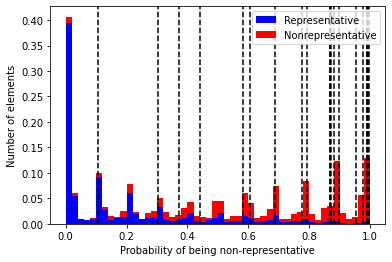

graph auc: 0.8522363742985494
graph auc: 0.8404777798906429
graph auc: 0.8369951729908852
graph auc: 0.8144065771411896
graph auc: 0.8241984088607858


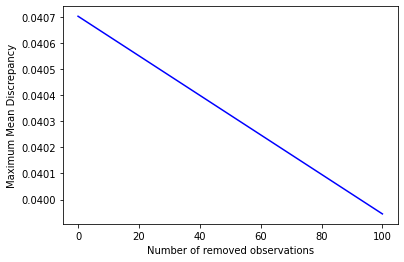

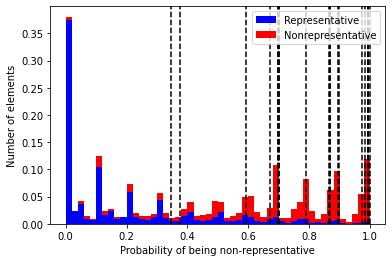

graph auc: 0.8365709874008338
graph auc: 0.7762761985062532


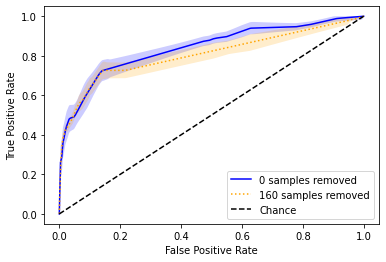

graph auc: 0.8151154731266823
graph auc: 0.8045262337233503
graph auc: 0.7970947143060312


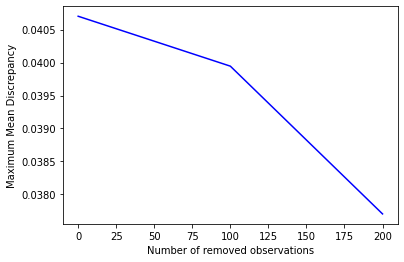

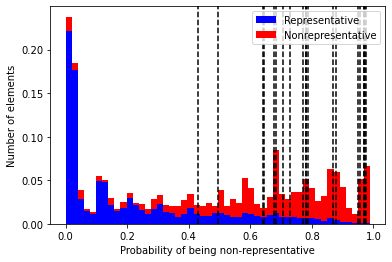

graph auc: 0.7861970183418346
graph auc: 0.7711020291940228
graph auc: 0.7398854669812566
graph auc: 0.742999619046277
graph auc: 0.7346975458027734


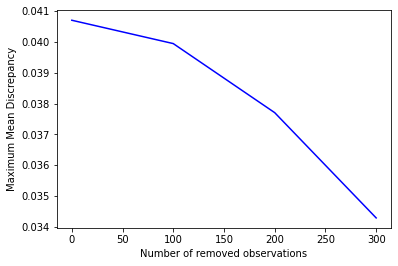

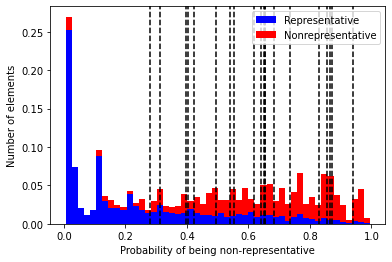

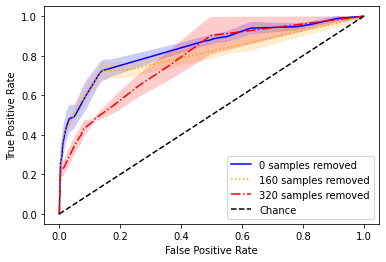

graph auc: 0.7599392650013653
graph auc: 0.7822398104619388
graph auc: 0.7425002640325811
graph auc: 0.7188817773371919
graph auc: 0.6572064425770308


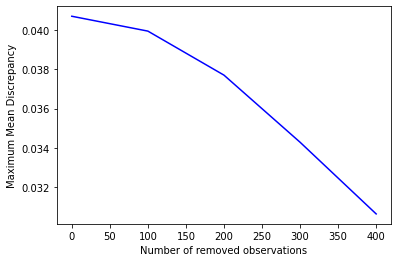

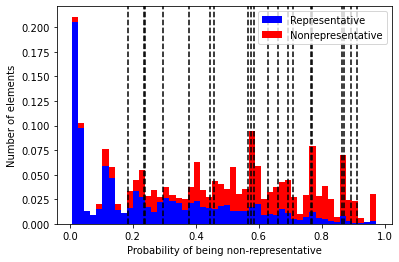

graph auc: 0.6611494794914432
graph auc: 0.7246340980051228
graph auc: 0.6000715459840924


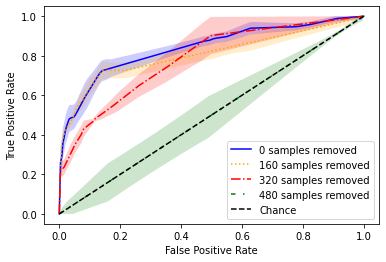

graph auc: 0.5510882352941177
graph auc: 0.5572631330977621


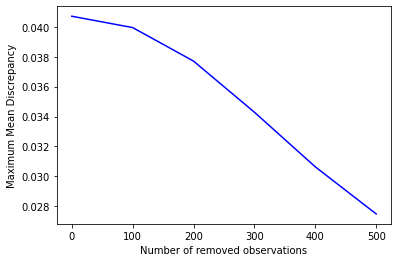

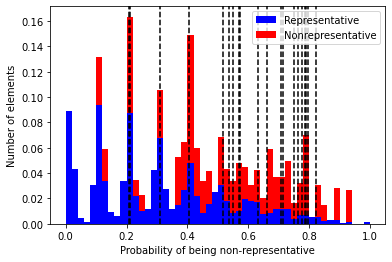

graph auc: 0.5
graph auc: 0.5218934040047114
graph auc: 0.5


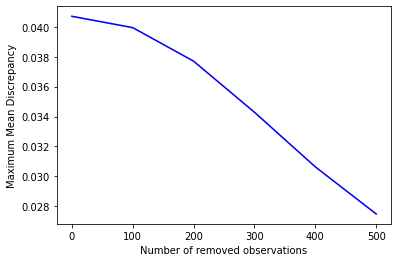

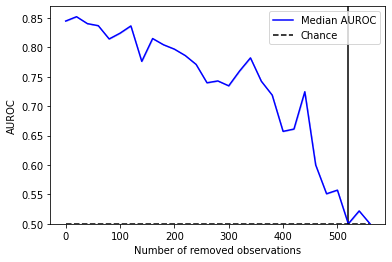

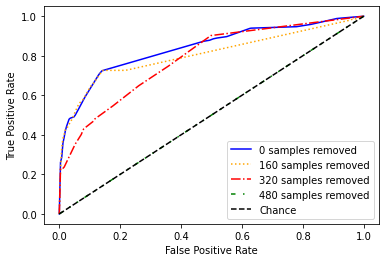

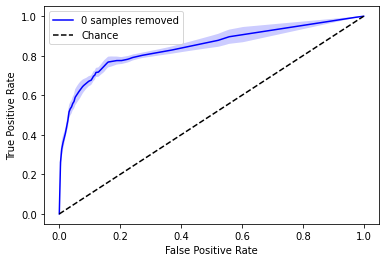

  0%|          | 0/28 [00:00<?, ?it/s]

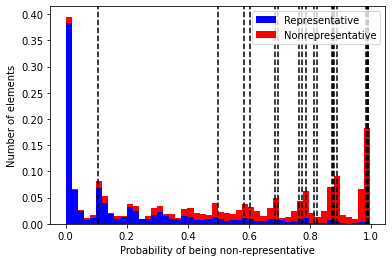

graph auc: 0.8519762391968536
graph auc: 0.827994405848084
graph auc: 0.8371110088944892
graph auc: 0.8333458306616361
graph auc: 0.850135950933594


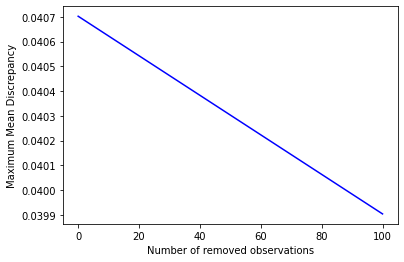

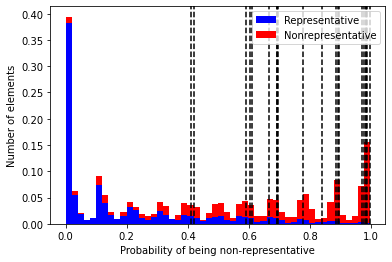

graph auc: 0.8219378734345885
graph auc: 0.8205085276752792


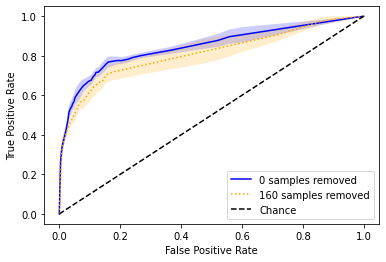

graph auc: 0.820312046078028
graph auc: 0.8262228398439933
graph auc: 0.810890751749463


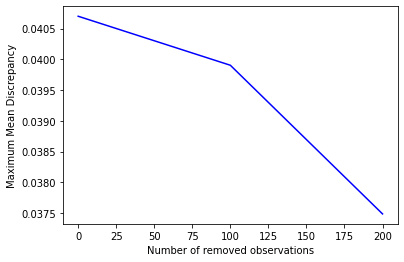

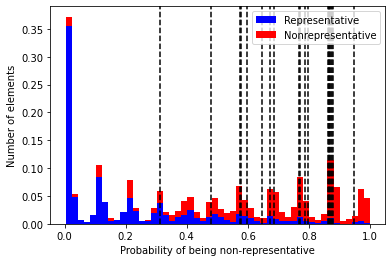

graph auc: 0.837447483553329
graph auc: 0.8524391391435598
graph auc: 0.8370669374787607
graph auc: 0.8118189370639554
graph auc: 0.7673524673345085


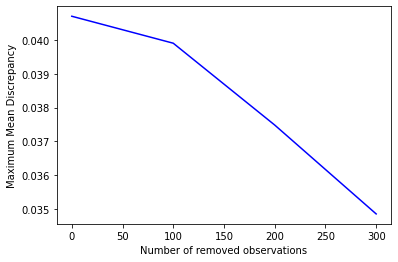

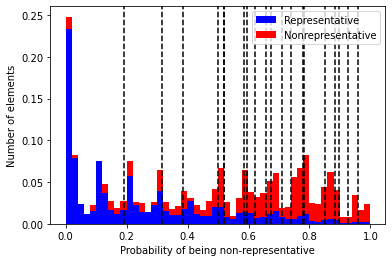

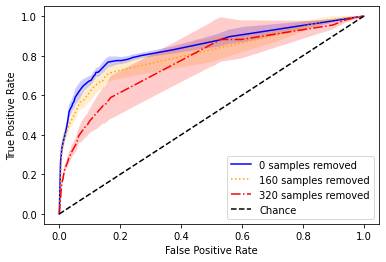

graph auc: 0.7678875446633893
graph auc: 0.6614057391257132
graph auc: 0.711239737042592
graph auc: 0.6699473370321218
graph auc: 0.5953757757519968


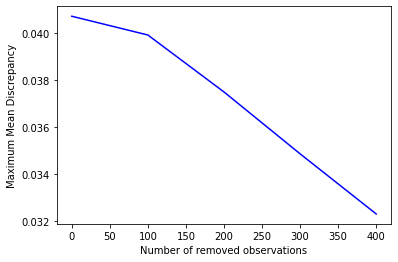

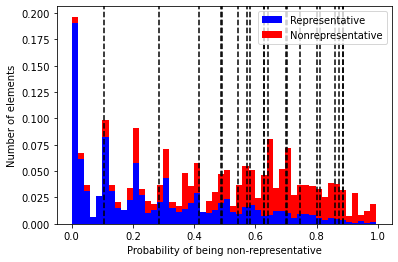

graph auc: 0.6491650670897562
graph auc: 0.5504610955493308
graph auc: 0.5982203751065645


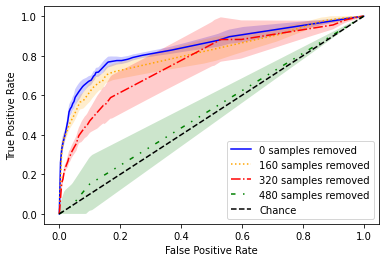

graph auc: 0.5663898219358415
graph auc: 0.5587992967505023


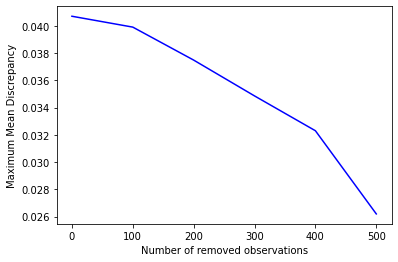

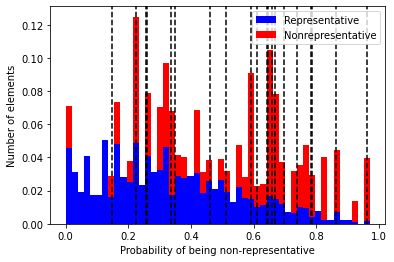

graph auc: 0.5
graph auc: 0.5433298319327731
graph auc: 0.5167550058892815


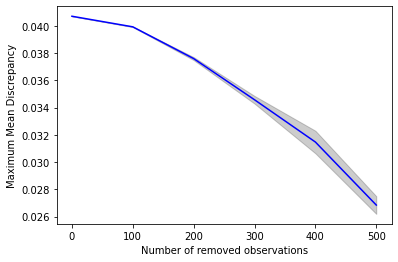

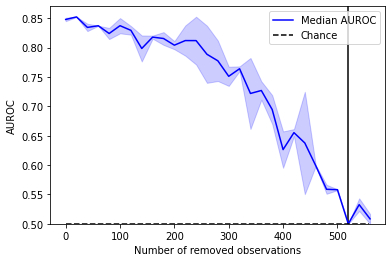

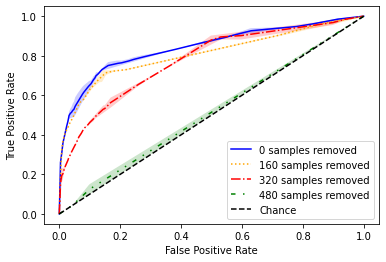

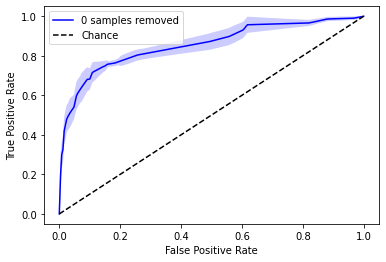

  0%|          | 0/28 [00:00<?, ?it/s]

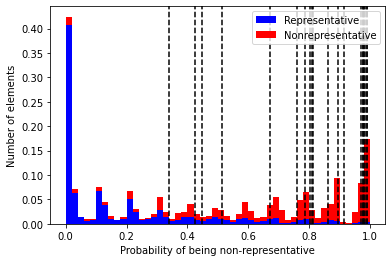

graph auc: 0.8438015379344366
graph auc: 0.855777519569363
graph auc: 0.8384447693773092
graph auc: 0.8242844880314264
graph auc: 0.8197314768421782


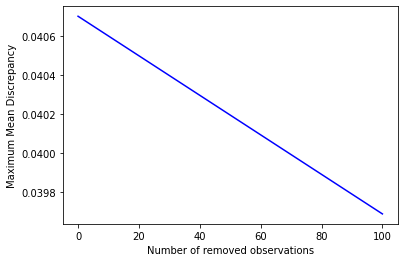

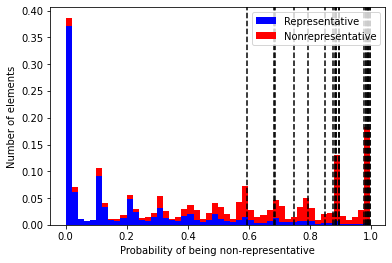

graph auc: 0.8162540421796429
graph auc: 0.8362768358692104


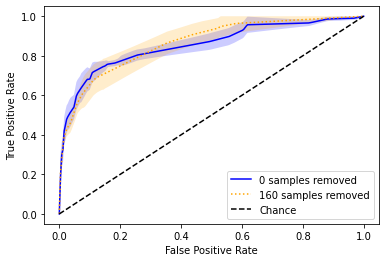

graph auc: 0.8435184939856427
graph auc: 0.8232431551244643
graph auc: 0.7769775751475966


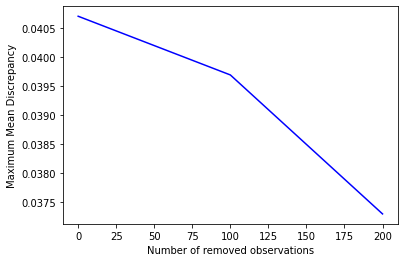

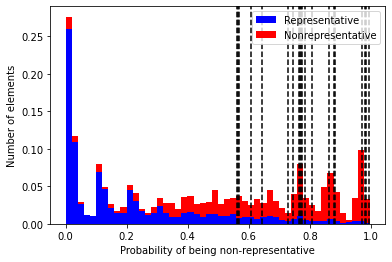

graph auc: 0.8166698148814981
graph auc: 0.7525093826111962
graph auc: 0.7992033412599433
graph auc: 0.7483163272256259
graph auc: 0.6896341296235808


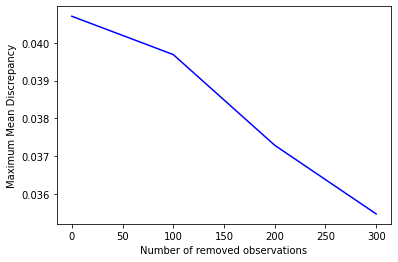

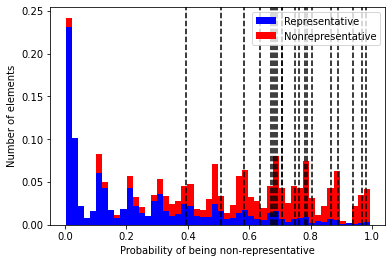

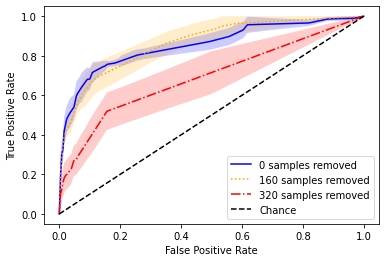

graph auc: 0.7043875387067031
graph auc: 0.6294569743392432
graph auc: 0.6936303982578098
graph auc: 0.6509285323697297
graph auc: 0.6670401821663098


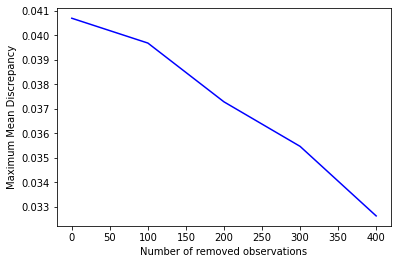

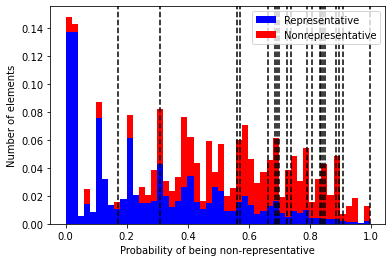

graph auc: 0.5587986242884251
graph auc: 0.5234982332155477
graph auc: 0.5720006524400102


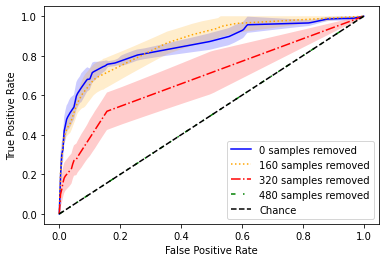

graph auc: 0.5
graph auc: 0.5298382352941177


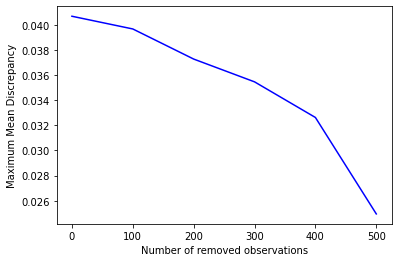

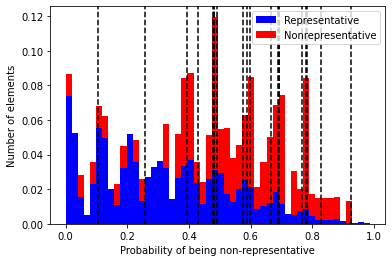

graph auc: 0.5
graph auc: 0.5
graph auc: 0.4908235294117647


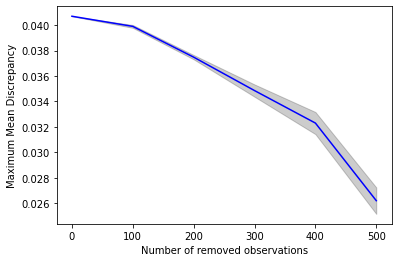

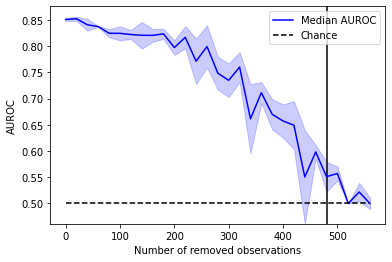

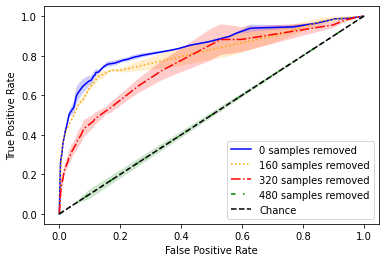

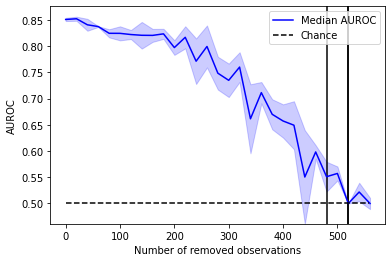

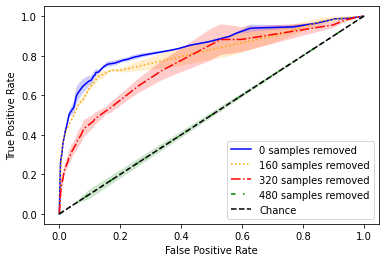

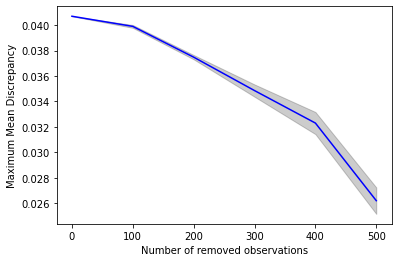

In [24]:
drop = 20
number_of_splits = 5
result_dir_temperature = os.path.join(os.getcwd(), 'results/temperature_comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

cv= 5
test_size = 0.3
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) / drop)
os.makedirs(result_dir_temperature, exist_ok=True)
aucs_without_temperature = []
rocs_without_temperature = []
mmds_without_temperature = []
mrs_iterations = []
mmd_iteration = 5
    
for _ in tqdm(range(3)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_gesis_gbs, gesis_columns,
                     number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv, directory=result_dir_temperature,
                                                 number_of_iterations=number_of_iterations, temperature_sampling=False)
    
    aucs_without_temperature.append(auc)
    rocs_without_temperature.append(roc)
    mmds_without_temperature.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs_without_temperature)
    median_mmds = np.median(mmds_without_temperature, axis = 0)
    std_mmds = np.std(mmds_without_temperature, axis = 0)
    median_aucs = np.median(aucs_without_temperature, axis = 0)
    std_aucs = np.std(aucs_without_temperature, axis = 0)
    
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iteration)
    plot_rocs(median_rocs, '', save=False)
    
plot_auc_median(median_aucs, std_aucs, drop, result_dir_temperature + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_temperature + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_temperature + "/median_mmds", save=True)


pickle.dump(median_aucs, open(result_dir_temperature + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_temperature + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_temperature + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_temperature + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_temperature + "/std_mmds", 'wb'))

### Save results

In [25]:
pickle.dump(median_aucs, open("results/median_aucs_without_temperature", 'wb'))
pickle.dump(std_aucs, open("results/std_aucs_without_temperature", 'wb'))
pickle.dump(median_rocs, open("results/median_rocs_without_temperature", 'wb'))
pickle.dump(median_mmds, open("results/median_mmds_without_temperature", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_temperature", 'wb'))
pickle.dump(mrs_iterations, open("results/mrs_iterations_without_temperature", 'wb'))

### Load saved results

In [26]:
median_aucs_without_temperature = pickle.load(open("results/median_aucs_without_temperature", 'rb'))
std_aucs_without_temperature = pickle.load(open("results/std_aucs_without_temperature", 'rb'))
median_aucs_temperature = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs_temperature = pickle.load(open("results/gesis_std_aucs", 'rb'))

median_mmds_without_temperature = pickle.load(open("results/median_mmds_without_temperature", 'rb'))
std_mmds_without_temperature = pickle.load(open("results/std_mmds_without_temperature", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

mrs_iterations_without_temperature = pickle.load(open("results/mrs_iterations_without_temperature", 'rb'))

### Visualise results

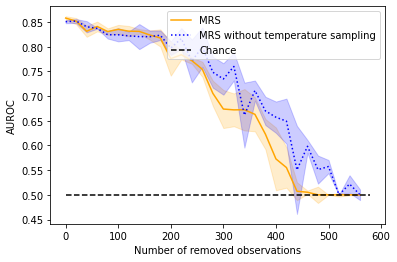

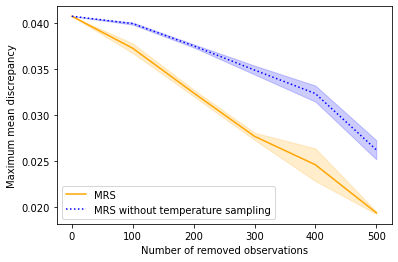

In [27]:
experiment_label = 'MRS without temperature sampling'   
file_directory = 'final/temperature_comparison/'
save = False
plot_experiment_comparison_auc(median_aucs_temperature, std_aucs_temperature, median_aucs_without_temperature, 
                                std_aucs_without_temperature, experiment_label, 
                           drop, file_directory + 'aucs', save=save)   
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_without_temperature, 
                               std_mmds_without_temperature, 
                               experiment_label, drop, mmd_iteration, 
                               file_directory + 'mmds',  save=save)

# Compare MRS with cross-validation and without

In [ ]:
def MRS_without_cv(N: pd.DataFrame, R: pd.DataFrame, columns: list, number_of_splits = 5,
        n_drop: int=1, cv=5):
    EPSILON = 10e-16 # to avoid dividing by zero
    preds = []
    bootstrap_iterations = 25
    kf = KFold(n_splits=number_of_splits)
    bootstrap_predictions_n = np.zeros(len(N))
    bootstrap_predictions_r = np.zeros(len(R))
    counter_n = np.zeros(len(N))
    counter_r = np.zeros(len(R))
    
    n = min(len(R), len(N))
    for _ in range(bootstrap_iterations):
        n_sample = N.sample(n=n, replace=True)
        N_test = N.drop(n_sample.index)
        r_sample = R.sample(n=n, replace=True)
        R_test = R.drop(r_sample.index)
        locations_not_in_bootstrap_n = list(set([N.index.get_loc(index) for index in N_test.index]))
        locations_not_in_bootstrap_r = list(set([R.index.get_loc(index) for index in R_test.index]))
        
        bootstrap = pd.concat([n_sample, r_sample])
        clf = grid_search(bootstrap[columns], bootstrap.label, 5)
        proba_n = clf.predict_proba(N_test[columns])[:,1]
        proba_r = clf.predict_proba(R_test[columns])[:,1]
        bootstrap_single_n = np.zeros(len(N))
        bootstrap_single_n[list(locations_not_in_bootstrap_n)] = proba_n
        counter_n[list(locations_not_in_bootstrap_n)] += 1
        bootstrap_predictions_n += bootstrap_single_n
        
        bootstrap_single_r = np.zeros(len(R))
        bootstrap_single_r[list(locations_not_in_bootstrap_r)] = proba_r
        counter_r[list(locations_not_in_bootstrap_r)] += 1
        bootstrap_predictions_r += bootstrap_single_r
        
    counter_n = [EPSILON if x == 0 else x for x in counter_n]
    counter_r = [EPSILON if x == 0 else x for x in counter_r]
    preds_n = bootstrap_predictions_n / counter_n
    preds_r = bootstrap_predictions_r / counter_r
    
    all_preds = np.concatenate([preds_n, preds_r])
    all_true = np.concatenate([np.ones(len(preds_n)), np.zeros(len(preds_r))])
    auc = roc_auc_score(all_true, all_preds)
    mapped_auc = abs(auc - 0.5)
    temperature = 0.35 * - np.log2(mapped_auc) - 0.35
    drop_ids = temperature_sample(preds_n, temperature, n_drop)
    return N.drop(N.index[drop_ids])



In [37]:
def repeated_MRS_without_cv(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, directory='', 
                 compas_bias='', temperature_sampling=True, number_of_iterations=None):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    if number_of_iterations is None:
        number_of_iterations = int(len(N) / drop)
    aucs = []
    rocs = []
    ratio = []
    mmds = []
    kl_values = []
    mmd_iteration = 5
    
    auroc_iteration = int(int(len(N) / n_drop) / 3.5) + 1
    
    if us:
        representative_ratio = (len(R[R[compas_bias] == 1]) /
                                len(R[R[compas_bias] == 0]))
        ratio.extend([len(N[N[compas_bias] == 1]) / 
                         (len(N[N[compas_bias] == 0]))]*drop)
        
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    rocs.append(roc)
    plot_rocs(rocs, '', save=False)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    mrs = N
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS_without_cv(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv)
        
        if((i+1) % auroc_iteration == 0):
            auc, roc = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=True)
            aucs.append(auc)
            rocs.append(roc)
            plot_rocs(rocs, '', save=False)
        else:
            auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
            aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * n_drop
            mrs = N.copy(deep=True)
            
        print(f'graph auc: {auc}')
        
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    
    
    return aucs, rocs, mrs, mmds, mrs_iteration 

  0%|          | 0/3 [00:00<?, ?it/s]

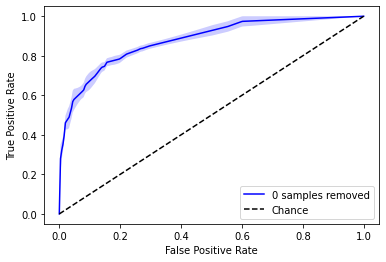

  0%|          | 0/28 [00:00<?, ?it/s]

graph auc: 0.8402401912632114
graph auc: 0.8341943655957271
graph auc: 0.8450339993139737
graph auc: 0.8394544542914071
graph auc: 0.838225121766517


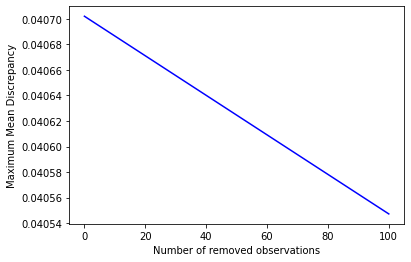

graph auc: 0.8289067013737199
graph auc: 0.8514445994865042
graph auc: 0.8362714936514577


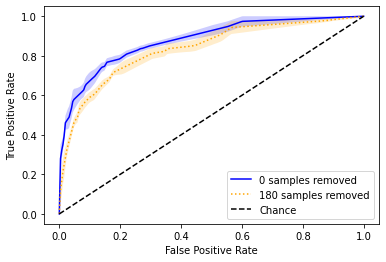

graph auc: 0.8372059294058009
graph auc: 0.8476776477152141


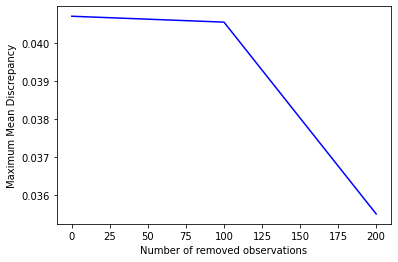

graph auc: 0.8288390516234585
graph auc: 0.8273447329238361
graph auc: 0.7791882762675153
graph auc: 0.8107221150055917
graph auc: 0.7327517051921957


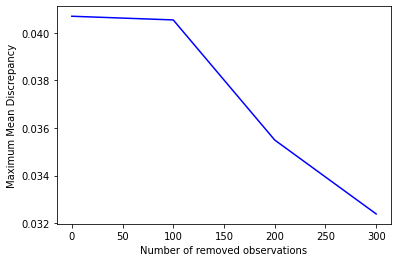

graph auc: 0.5757091207523733
graph auc: 0.7164702751599099


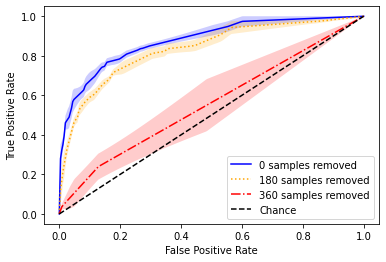

graph auc: 0.566829368303698
graph auc: 0.6054766214177979
graph auc: 0.5638711484593838


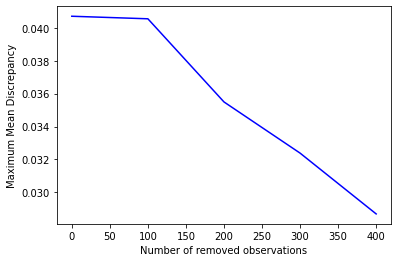

graph auc: 0.5230602179034157
graph auc: 0.5066258948023654
graph auc: 0.5178052610914802
graph auc: 0.505
graph auc: 0.5


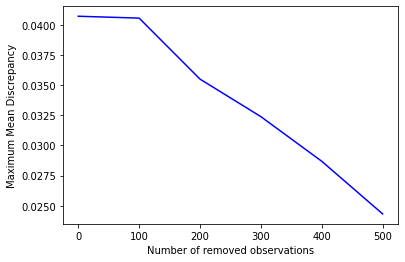

graph auc: 0.5


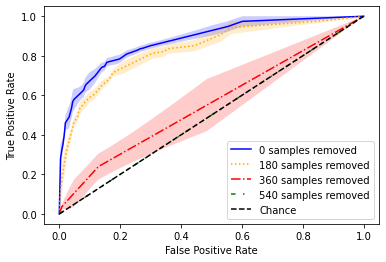

graph auc: 0.5
graph auc: 0.5


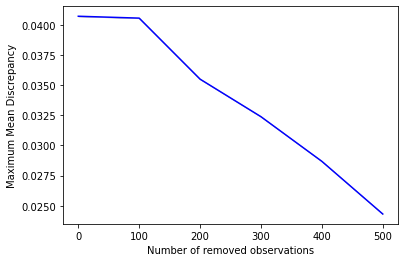

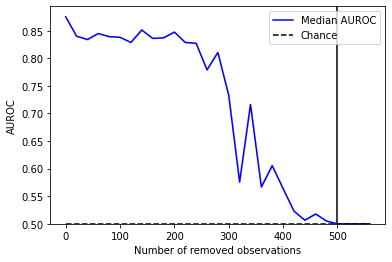

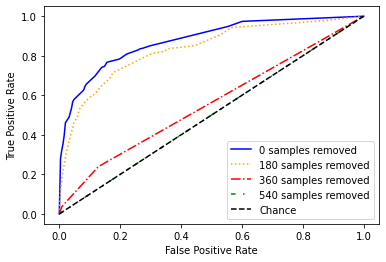

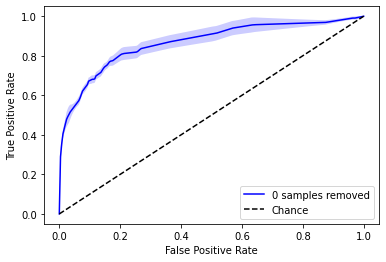

  0%|          | 0/28 [00:00<?, ?it/s]

graph auc: 0.8539935827162495
graph auc: 0.8331852767506639
graph auc: 0.8415162032728603
graph auc: 0.8364096498974363
graph auc: 0.8375067944774465


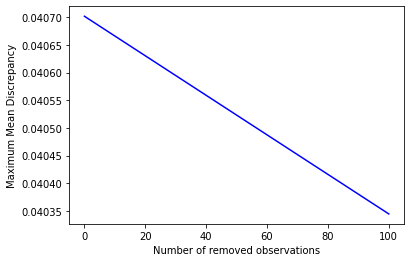

graph auc: 0.8285037499169515
graph auc: 0.8466228496194826
graph auc: 0.8541256991621203


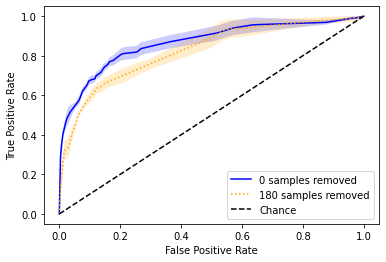

graph auc: 0.8169238092513027
graph auc: 0.810670822639638


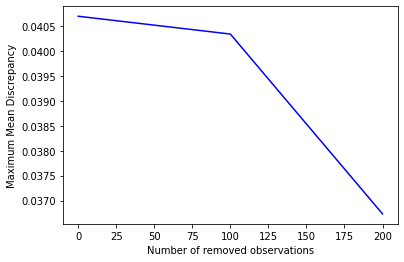

graph auc: 0.7979289401234151
graph auc: 0.8000108812254524
graph auc: 0.760566883349335
graph auc: 0.7621779617566619
graph auc: 0.6977920230604288


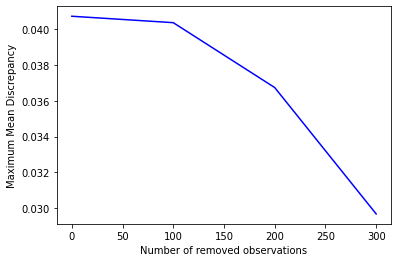

graph auc: 0.7312733176829244
graph auc: 0.6694915898996243


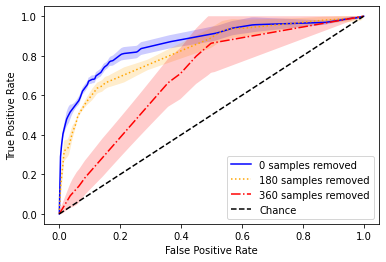

graph auc: 0.6706888487725378
graph auc: 0.6689222017918339
graph auc: 0.6246465919701214


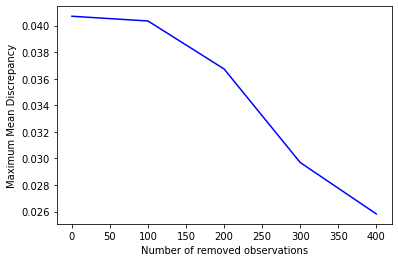

graph auc: 0.5951743358633776
graph auc: 0.550235294117647
graph auc: 0.5
graph auc: 0.5052631578947369
graph auc: 0.5877941176470588


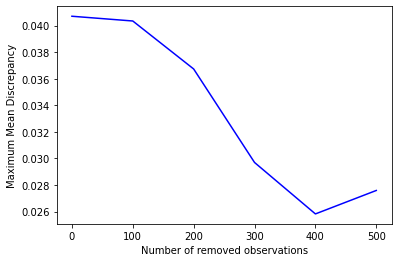

graph auc: 0.5


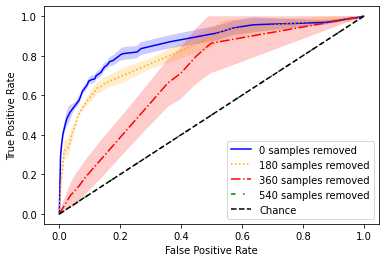

graph auc: 0.5
graph auc: 0.5


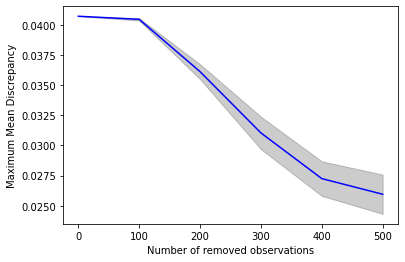

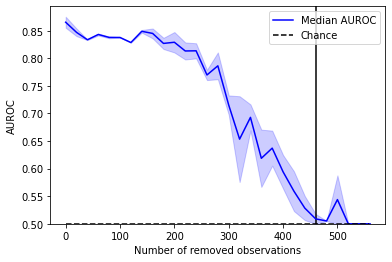

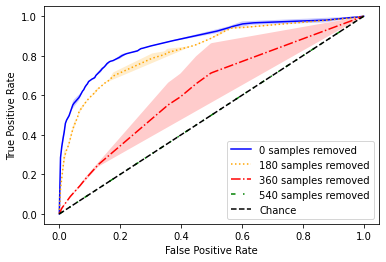

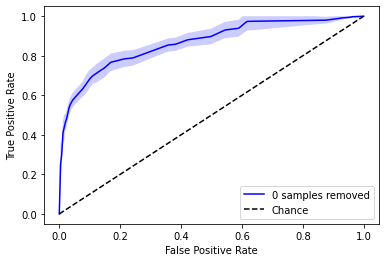

  0%|          | 0/28 [00:00<?, ?it/s]

graph auc: 0.8392007496628677
graph auc: 0.842621741496264
graph auc: 0.843832808813944
graph auc: 0.8349142780538706
graph auc: 0.8183618784346546


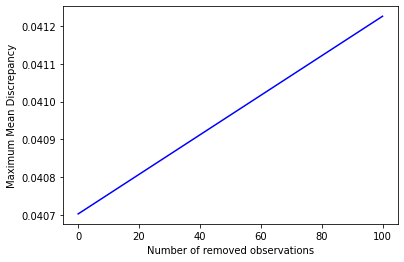

graph auc: 0.8298443147636165
graph auc: 0.8375903040902216
graph auc: 0.7908243897783332


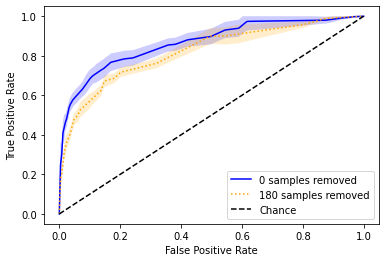

graph auc: 0.8232746761772203
graph auc: 0.8301506554059228


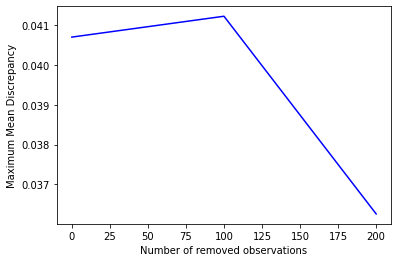

graph auc: 0.8209246177930576
graph auc: 0.8013057412145747
graph auc: 0.7795922224160572
graph auc: 0.7884339798429603
graph auc: 0.7579830147092566


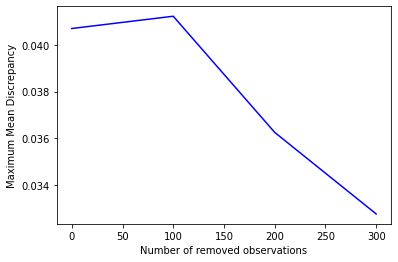

graph auc: 0.7003208192763379
graph auc: 0.7308658507911097


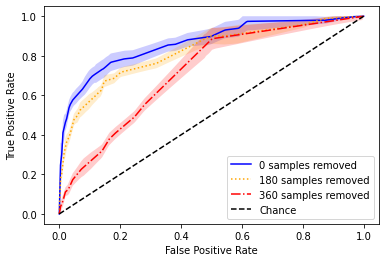

graph auc: 0.7150433758290293
graph auc: 0.7195042698623348
graph auc: 0.668442143170578


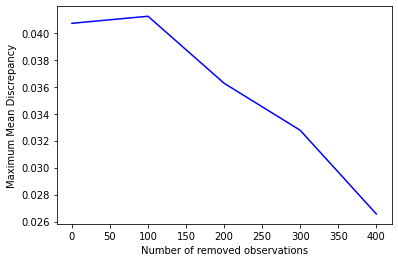

graph auc: 0.6084335969541128
graph auc: 0.5931011515717397
graph auc: 0.5838565490517402
graph auc: 0.5
graph auc: 0.5


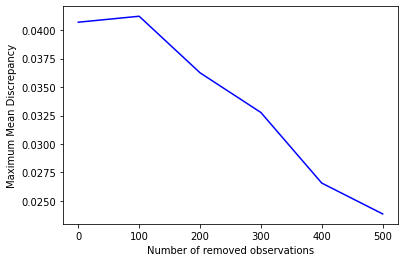

graph auc: 0.5


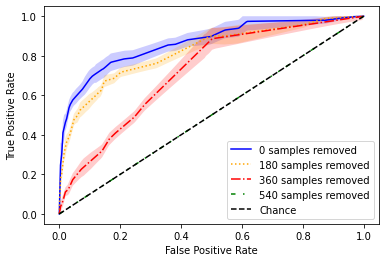

graph auc: 0.5
graph auc: 0.5359999999999999


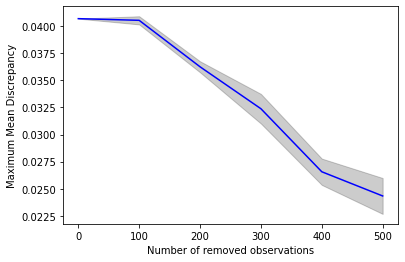

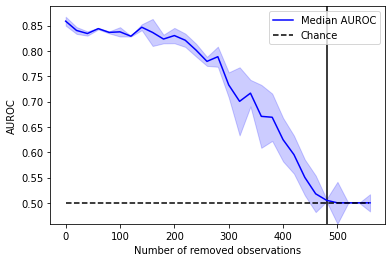

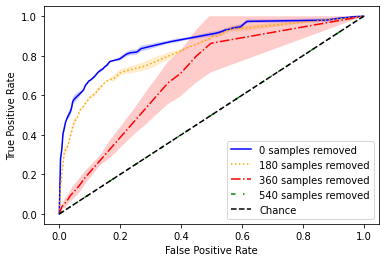

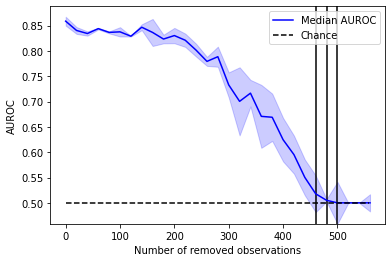

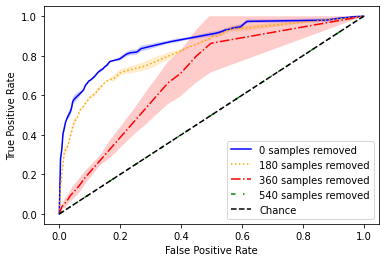

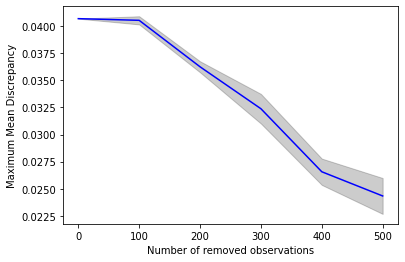

In [38]:
drop = 20
number_of_splits = 5
result_dir_cv = os.path.join(os.getcwd(), 'results/cv__comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.5
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) / drop)

os.makedirs(result_dir_cv, exist_ok=True)
cv = 5
aucs_without_cv = [] 
aucs_without_cv = []
rocs_without_cv = []
mmds_without_cv = []
mrs_iterations = []
mmd_iteration = 5
save=False
    
for temp in tqdm(range(3)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS_without_cv(scaled_gesis_gbs, gesis_columns, 
                    number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv, number_of_iterations=number_of_iterations)
    
    aucs_without_cv.append(auc)
    rocs_without_cv.append(roc)
    mmds_without_cv.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs_without_cv)
    median_mmds = np.median(mmds_without_cv, axis = 0)
    std_mmds = np.std(mmds_without_cv, axis = 0)
    median_aucs = np.median(aucs_without_cv, axis = 0)
    std_aucs = np.std(aucs_without_cv, axis = 0)
    
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=save)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iteration)
    plot_rocs(median_rocs, '', save=save)


plot_auc_median(median_aucs, std_aucs, drop, result_dir_cv + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_cv + "/median_rocs", save=save)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_cv + "/median_mmds", save=save)


pickle.dump(median_aucs, open(result_dir_cv + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_cv + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_cv + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_cv + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_cv + "/std_mmds", 'wb'))

### Save results

In [42]:
pickle.dump(median_aucs, open("results/median_aucs_without_cv", 'wb'))
pickle.dump(std_aucs, open("results/std_aucs_without_cv", 'wb'))
pickle.dump(median_mmds, open("results/median_mmds_without_cv", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_cv", 'wb'))

pickle.dump(median_rocs, open("results/median_rocs_without_cv", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_cv", 'wb'))
pickle.dump(mrs_iterations, open("results/mrs_iterations_without_cv", 'wb'))

### Load results

In [29]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
median_aucs_without_cv = pickle.load(open("results/median_aucs_without_cv", 'rb'))
std_aucs_without_cv = pickle.load(open("results/std_aucs_without_cv", 'rb'))

median_mmds_without_cv = pickle.load(open("results/median_mmds_without_cv", 'rb'))
std_mmds_without_cv = pickle.load(open("results/std_mmds_without_cv", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

mrs_iterations_without_temperature = pickle.load(open("results/mrs_iterations_without_cv", 'rb'))

### Visualise results

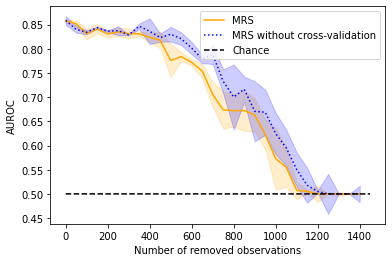

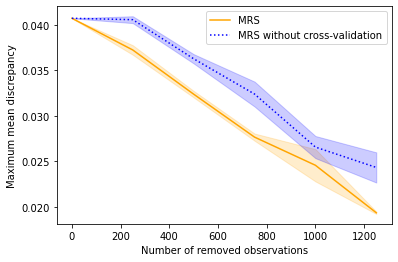

In [30]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/cross_validation_comparison/")
os.makedirs(file_directory, exist_ok=True)

experiment_label = 'MRS without cross-validation'


 
plot_experiment_comparison_auc(gesis_median_aucs, gesis_std_aucs, median_aucs_without_cv, 
                                std_aucs_without_cv, experiment_label, drop, 
                           file_directory+'auc', save=save)    
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_without_cv, 
                               std_mmds_without_cv, 
                               experiment_label, drop, mmd_iteration, file_directory+'mmd',  save=save)

# Random drops

### Run experiment

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

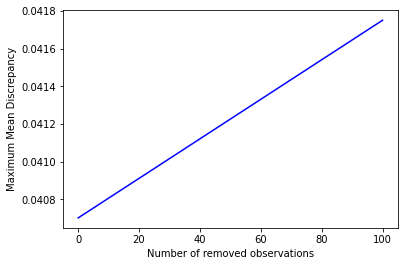

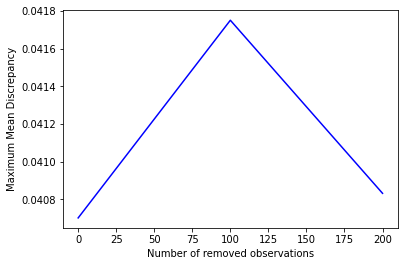

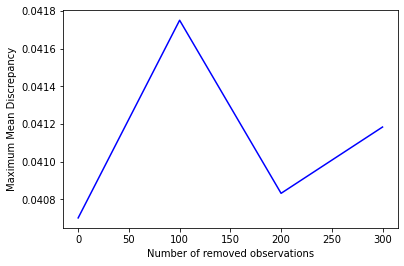

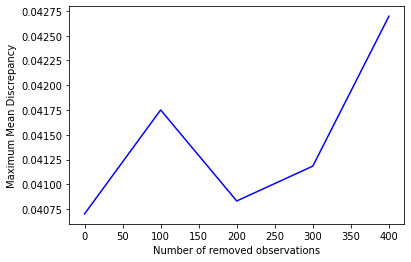

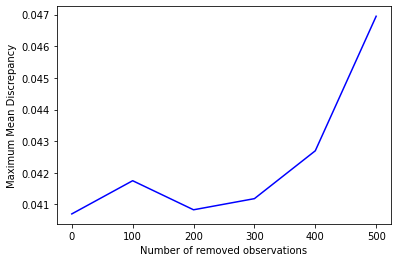

[500]


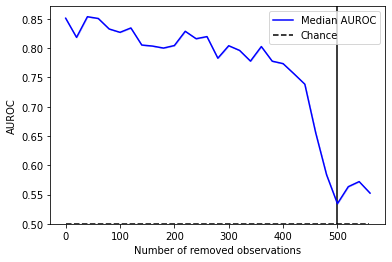

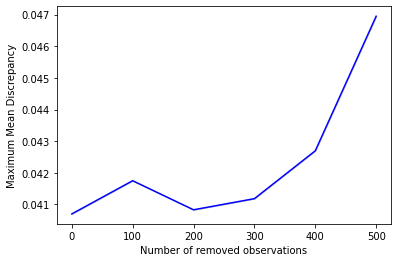

  0%|          | 0/28 [00:00<?, ?it/s]

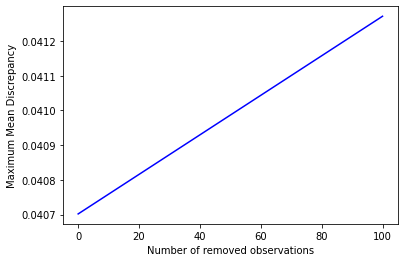

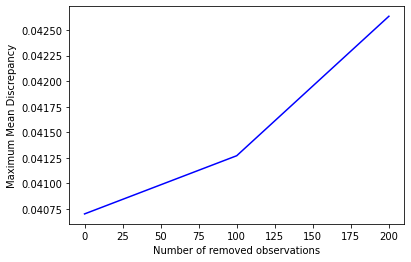

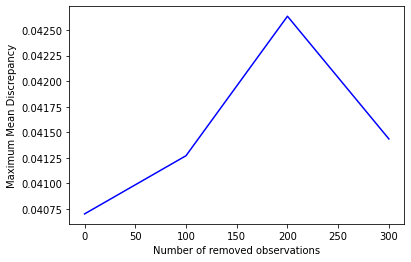

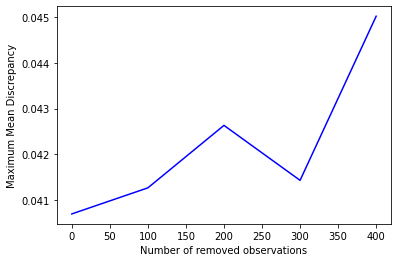

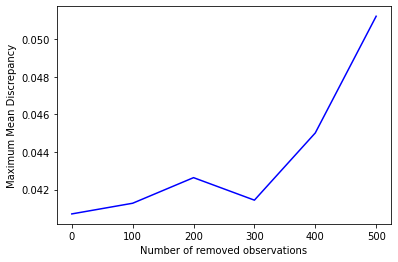

[500, 560]


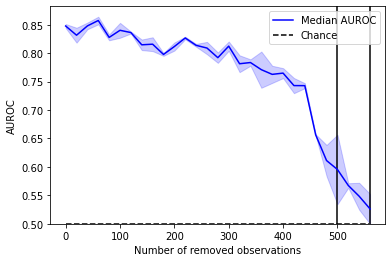

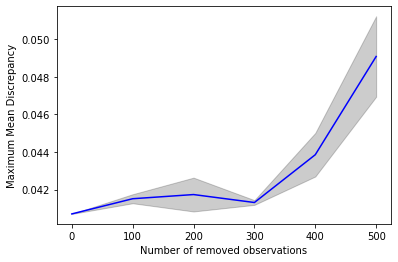

  0%|          | 0/28 [00:00<?, ?it/s]

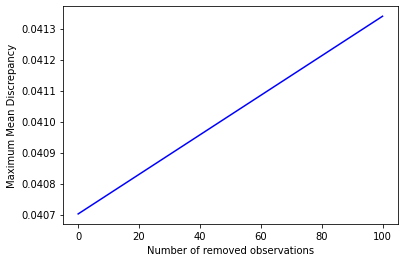

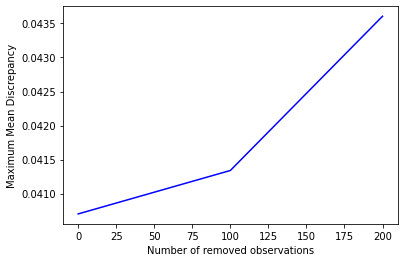

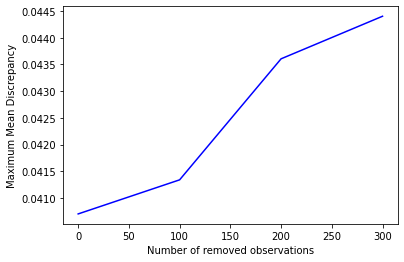

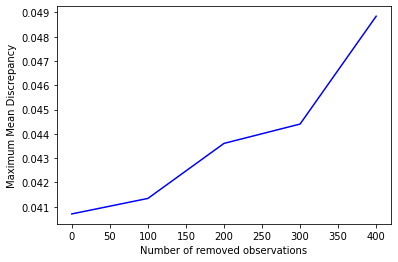

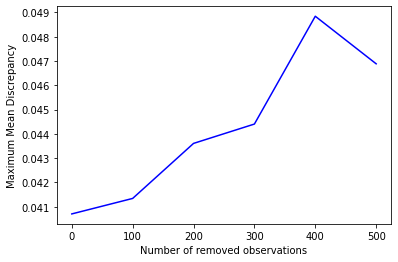

[500, 560, 560]


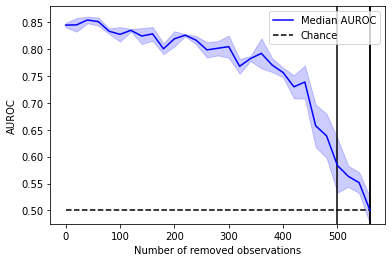

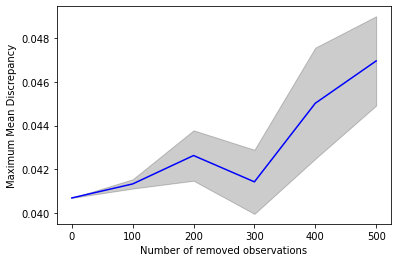

  0%|          | 0/28 [00:00<?, ?it/s]

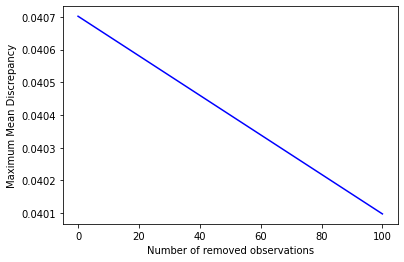

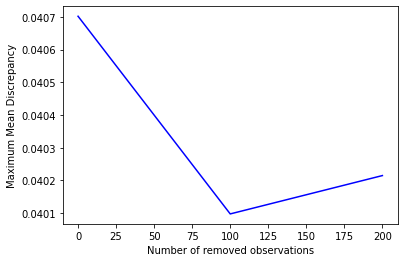

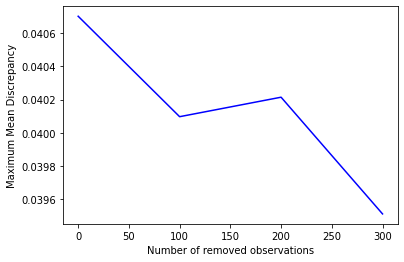

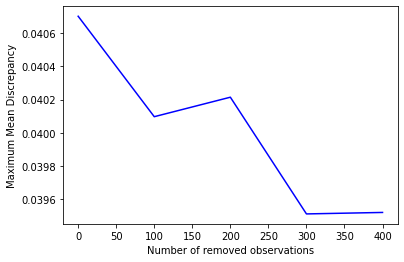

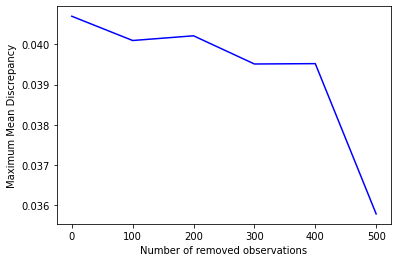

[500, 560, 560, 560]


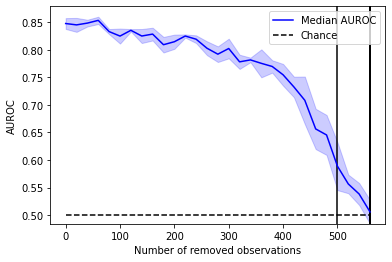

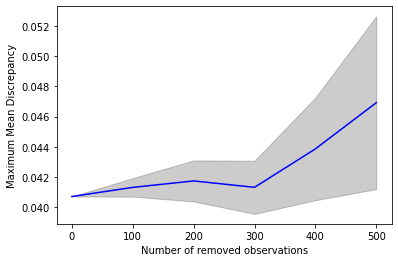

  0%|          | 0/28 [00:00<?, ?it/s]

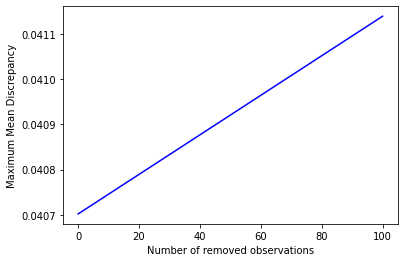

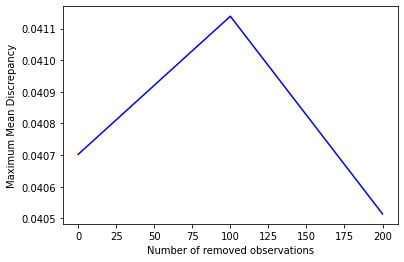

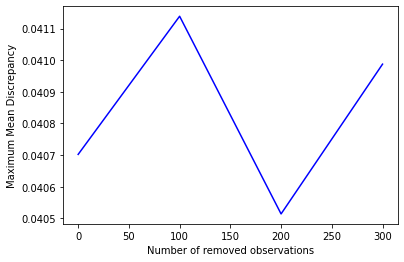

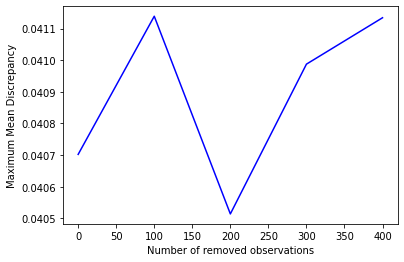

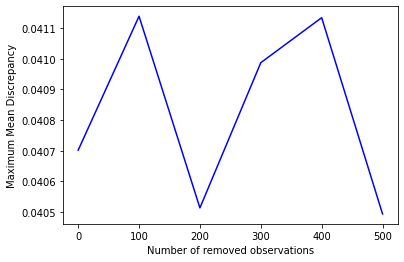

[500, 560, 560, 560, 560]


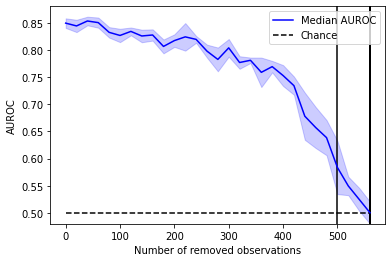

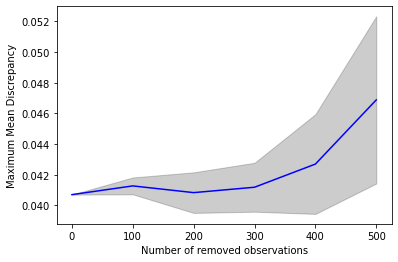

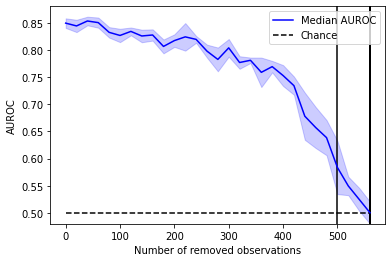

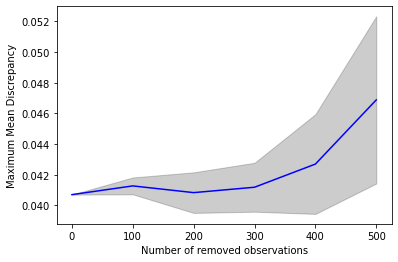

In [62]:
n_drop = 20
result_dir = os.path.join(os.getcwd(), 'results/random_drop',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
cv = 5
test_size = 0.3
number_of_splits = 5
aucs_random_drop = []
mmds = []
mrs_iterations = []
mmd_iteration = 5
os.makedirs(result_dir, exist_ok=True)

#compas_nonrep_more_young
#compas_nonrep_more_old 
#compas_rep
data = scaled_gesis_gbs
columns = gesis_columns
iterations = int(len(data[data['label'] == 1]) / drop) 
#data = compas_nonrep_more_young
#columns = compas_columns

for _ in tqdm(range(5)): 
    N = data[data['label'] == 1].copy()
    R = data[data['label'] == 0].copy()
    aucs = [] 
    mmd = []
    
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    mmd.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    
    for i in tqdm(range(iterations)):
        drop_ids = random.sample(range(0, len(N)), drop)
        N.drop(N.index[drop_ids], inplace=True)

        auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
        aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * n_drop
            
        if ((i+1) % mmd_iteration == 0):
            mmd.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmd, drop, mmd_iteration, '', False)
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
        
    mrs_iterations.append(mrs_iteration)
    aucs_random_drop.append(aucs)
    mmds.append(mmd)
    median_aucs_random_drop = np.median(aucs_random_drop, axis = 0)
    median_mmd_random_drop = np.median(mmds, axis = 0)
    std_aucs_random_drop = np.std(aucs_random_drop, axis = 0)
    std_mmds_random_drop = np.std(mmds, axis = 0)
    print(mrs_iterations)
    plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, drop, '', save=False, 
                   mrs_iteration=mrs_iterations)
    plot_mmds_median(median_mmd_random_drop, std_mmds_random_drop, drop, mmd_iteration, '', save=False)
    
plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, drop, 
                result_dir + '/random_drop_experiment_auc', save=True, mrs_iteration=mrs_iterations)
plot_mmds_median(median_mmd_random_drop, std_mmds_random_drop, drop, mmd_iteration,
               result_dir + '/random_drop_experiment_mmd', save=True)

pickle.dump(median_aucs_random_drop, open(result_dir + "/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open(result_dir + "/std_aucs_random_drop", 'wb'))
pickle.dump(median_mmds, open(result_dir + "/mmd_random_drop", 'wb'))

### Save results

In [63]:
pickle.dump(median_aucs_random_drop, open("results/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open("results/std_aucs_random_drop", 'wb'))
pickle.dump(median_mmd_random_drop, open("results/median_mmds_random_drop", 'wb'))
pickle.dump(std_mmds_random_drop, open("results/std_mmds_random_drop", 'wb'))

### Load saved results

In [64]:
median_aucs_random_drop = pickle.load(open("results/median_aucs_random_drop", 'rb'))
std_aucs_random_drop = pickle.load(open("results/std_aucs_random_drop", 'rb'))
median_mmds_random_drop = pickle.load(open("results/median_mmds_random_drop", 'rb'))
std_mmds_random_drop = pickle.load(open("results/std_mmds_random_drop", 'rb'))

gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

### Visualise results

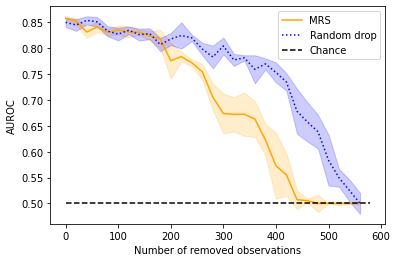

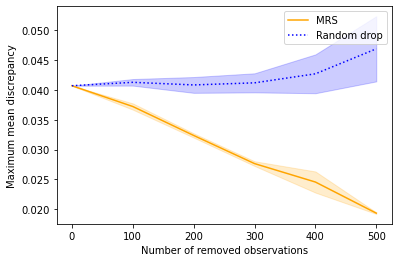

In [65]:
file_directory = os.path.join(os.getcwd(), "final_results/random/")
os.makedirs(file_directory, exist_ok=True)
save = False

experiment_label = 'Random drop'
file_name = result_dir + '/random_drop_experiment'
plot_experiment_comparison_auc(gesis_median_aucs, gesis_std_aucs,
                               median_aucs_random_drop, std_aucs_random_drop, 
                               experiment_label, drop, file_name+'aucs',  save)
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_random_drop, 
                               std_mmds_random_drop, 
                               experiment_label, drop, mmd_iteration, file_directory+'mmd',  save=save)